In [9]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(crayon)
}))

# Definitions etc

In [10]:
set.seed(1234)
options(digits=2)

In [11]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    prj_path = "/home/vsevim/prj/1012-ckd/S1/"
    data_subdir = "/analysis/primary/cellranger/backup/Screen1_66guides_L1/outs/"
    seurat_obj_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/Lib_1/seurat_objects/"
    seurat_obj_fname = "Screen1_66guides_Lib_1.h5seurat"
    library_name = "Lib_1"
    save_seurat_h5 = "NO"
}

In [12]:
data_path <- paste0(prj_path, data_subdir)
mx_path   <- paste0(data_path, "/filtered_feature_bc_matrix/")
h5_path   <- paste0(data_path, "/filtered_feature_bc_matrix.h5")
umi_thresholds_path <- paste0(data_path, "/crispr_analysis/protospacer_umi_thresholds.csv")
ps_calls_path <- paste0(data_path, "/crispr_analysis/protospacer_calls_per_cell.csv")
save_h5_file <- paste0(seurat_obj_path, seurat_obj_fname)

In [13]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

In [14]:
data_path

[1] "/home/vsevim/prj/1012-ckd/S1//analysis/primary/cellranger/backup/Screen1_66guides_L1/outs/"

### Load cell-cycle data

In [15]:
# A list of cell cycle markers, from Tirosh et al, 2015, is loaded with Seurat.  We can
# segregate this list into markers of G2/M phase and markers of S phase
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes


### Load 10x data

In [16]:
inputdata   <- Read10X_h5(h5_path)

Genome matrix has multiple modalities, returning a list of matrices for this genome



In [17]:
# extract RNA and sgRNA data
rna_counts   <- inputdata$`Gene Expression`
sgrna_counts <- inputdata$`CRISPR Guide Capture`

In [18]:
dim(rna_counts)
dim(sgrna_counts)

[1] 36601  9169

[1]  132 9169

In [19]:
n_cells_from_cellranger = ncol(rna_counts)
n_protospacers = nrow(sgrna_counts)
all_protospacer_ids = colnames(sgrna_counts)
n_genes = nrow(rna_counts)
cat(blue(prj_name, library_name), "\n")
cat(blue("#cells recovered:", n_cells_from_cellranger), "\n")
cat(blue("#genes recovered:", n_genes), "\n")
cat(blue("#protospacers in assay:", n_protospacers), "\n")

Screen1_66guides Lib_1 
#cells recovered: 9169 
#genes recovered: 36601 
#protospacers in assay: 132 


# Visualize protospacer counts

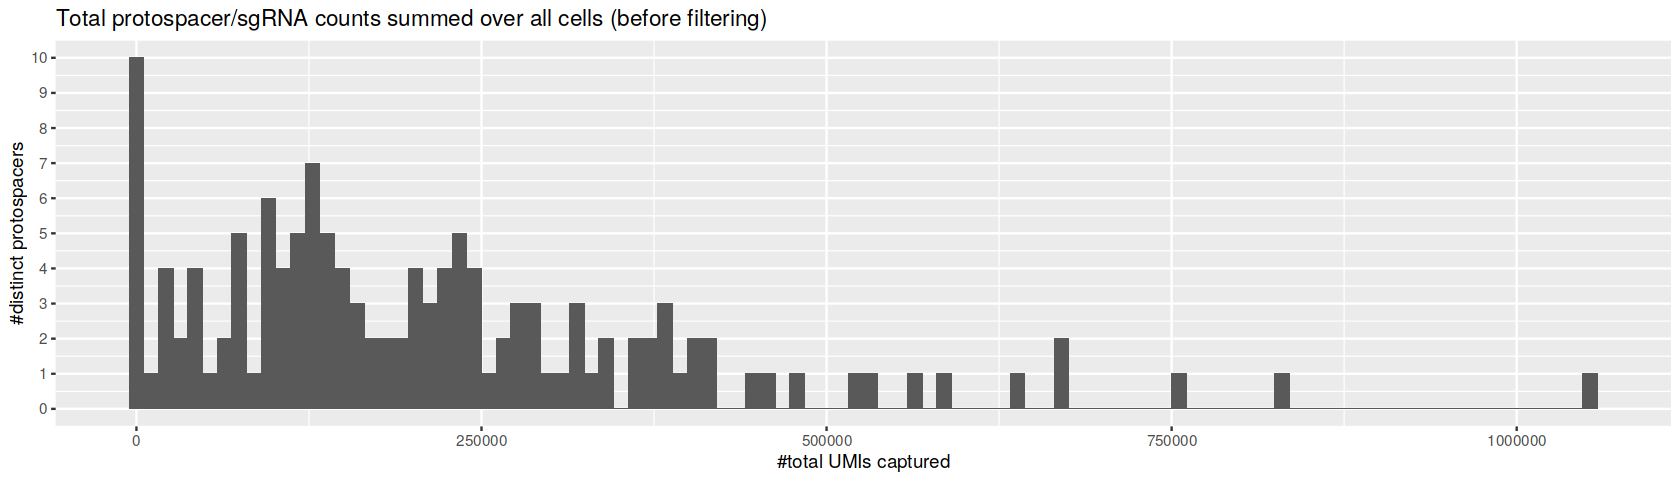

In [20]:
df_guide_counts = data.frame(total_guide_count=rowSums(sgrna_counts))
row.names(df_guide_counts) <- row.names(sgrna_counts)

options(repr.plot.width=14, repr.plot.height=4)
ggplot(df_guide_counts, aes(x = total_guide_count)) +
    geom_histogram(bins=100) +
    labs(title = "Total protospacer/sgRNA counts summed over all cells (before filtering)", x = "#total UMIs captured") +
    labs(y = "#distinct protospacers") +
    scale_y_continuous(breaks=seq(0,10, by=1))


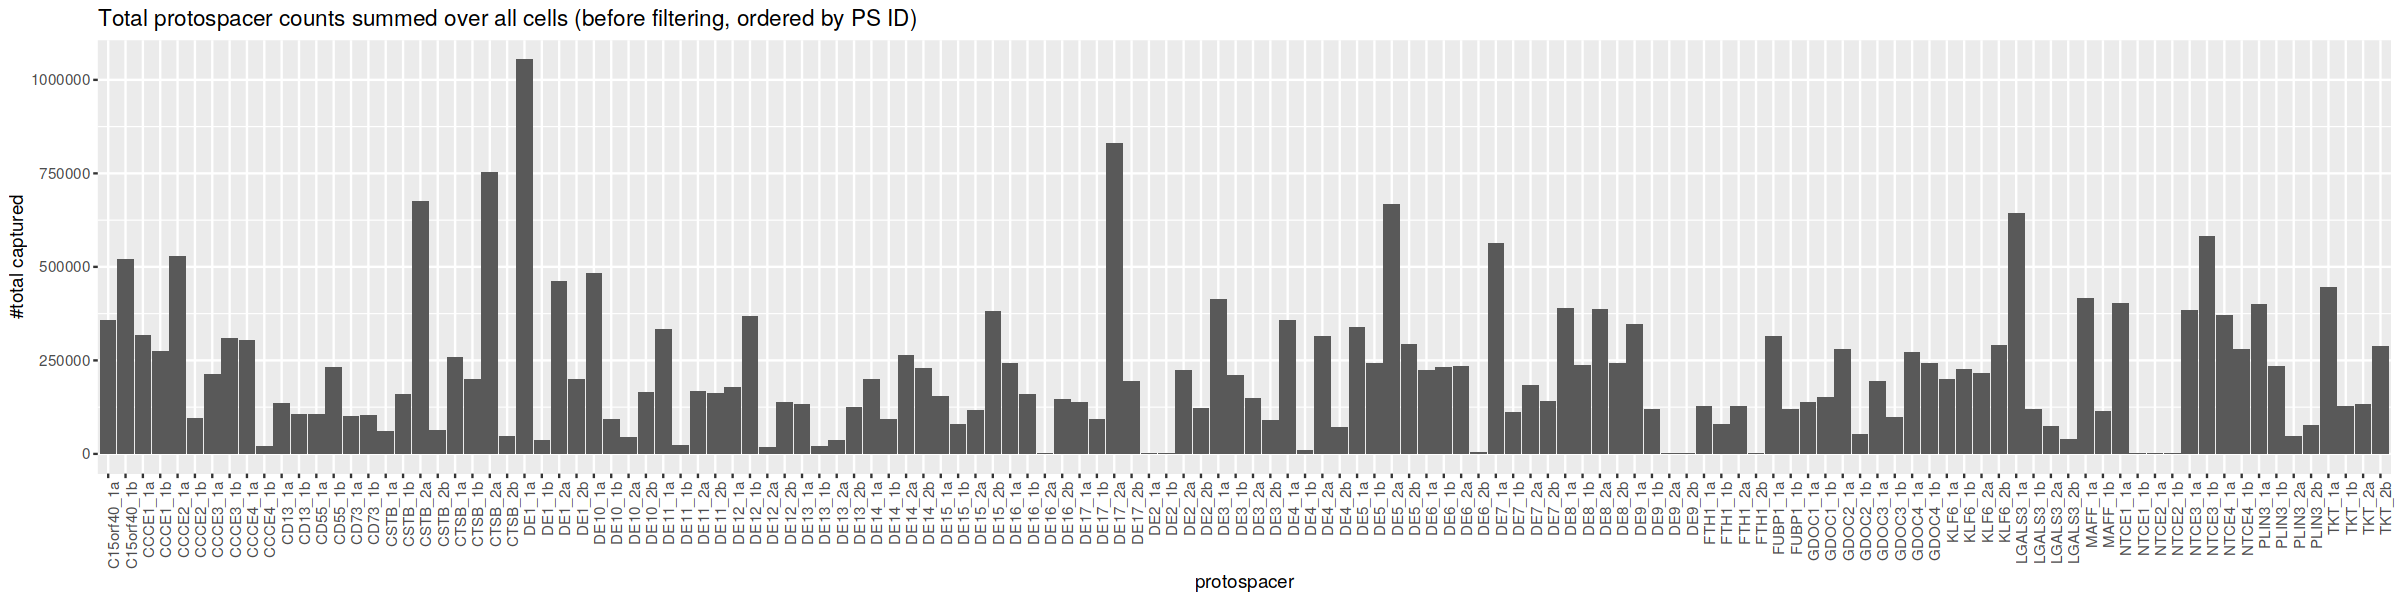

In [21]:
df_guide_counts_ordered <- df_guide_counts[order(df_guide_counts$total_guide_count),,drop=FALSE]
df_guide_counts_ordered$protospacer  <- rownames(df_guide_counts_ordered)

options(repr.plot.width=20, repr.plot.height=5)
ggplot(df_guide_counts_ordered, aes(x=protospacer, y=total_guide_count)) +
    geom_bar(stat='identity') + 
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(title = "Total protospacer counts summed over all cells (before filtering, ordered by PS ID)", x = "protospacer") +
    labs(y = "#total captured") 

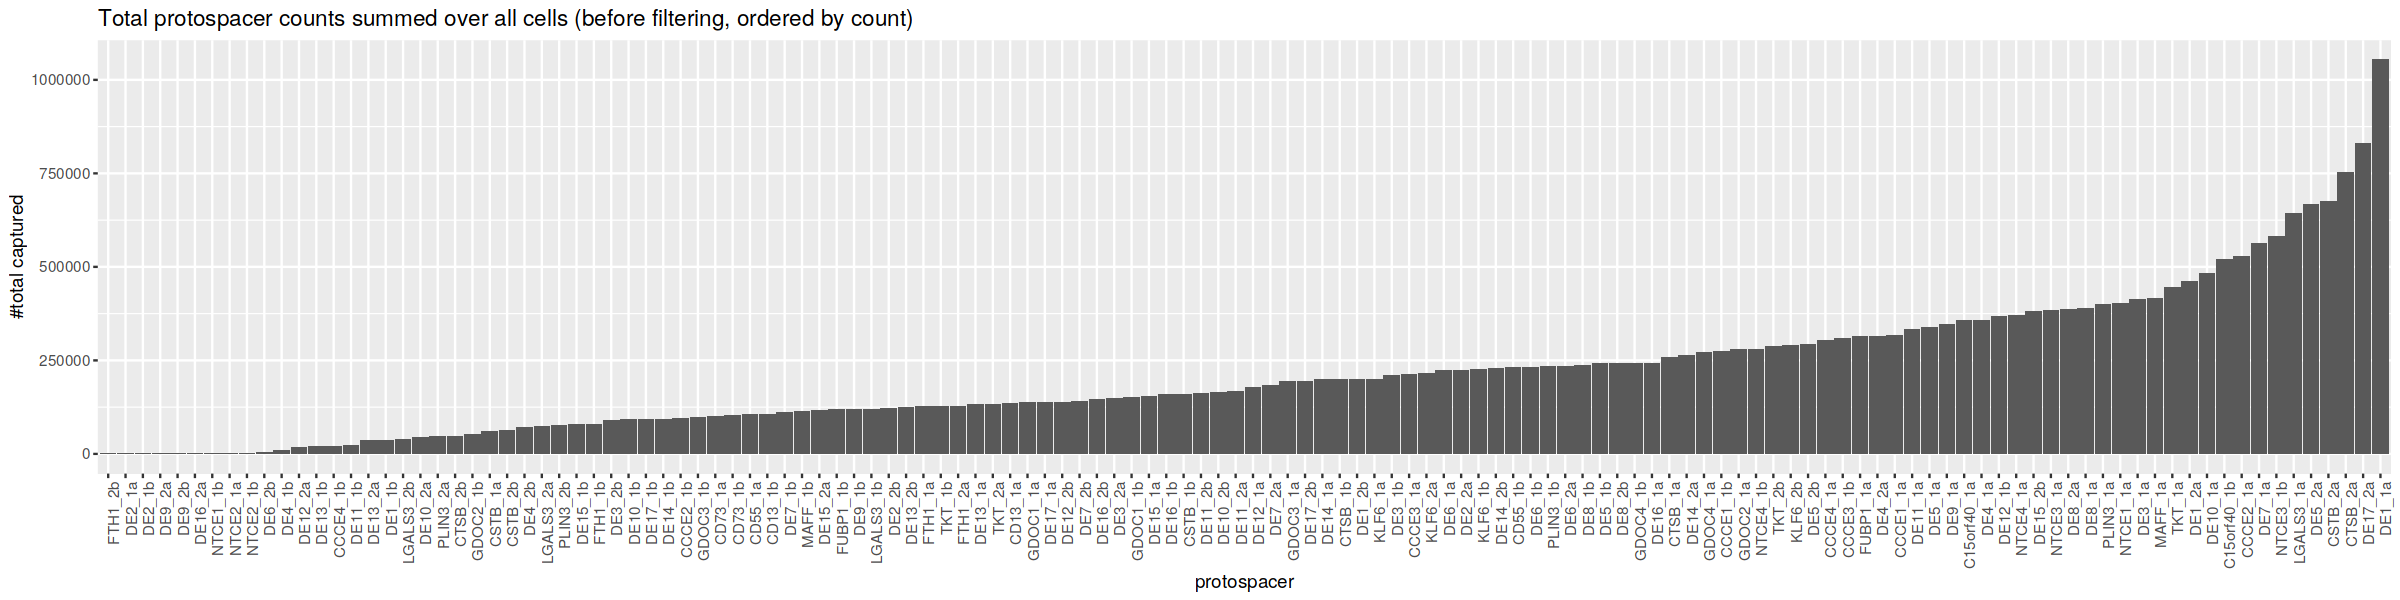

In [22]:
df_guide_counts_ordered$protospacer <- factor(df_guide_counts_ordered$protospacer, levels = df_guide_counts_ordered$protospacer)

options(repr.plot.width=20, repr.plot.height=5)
ggplot(df_guide_counts_ordered, aes(x=protospacer, y=total_guide_count)) +
    geom_bar(stat='identity') + 
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(title = "Total protospacer counts summed over all cells (before filtering, ordered by count)", x = "protospacer") +
    labs(y = "#total captured") 

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



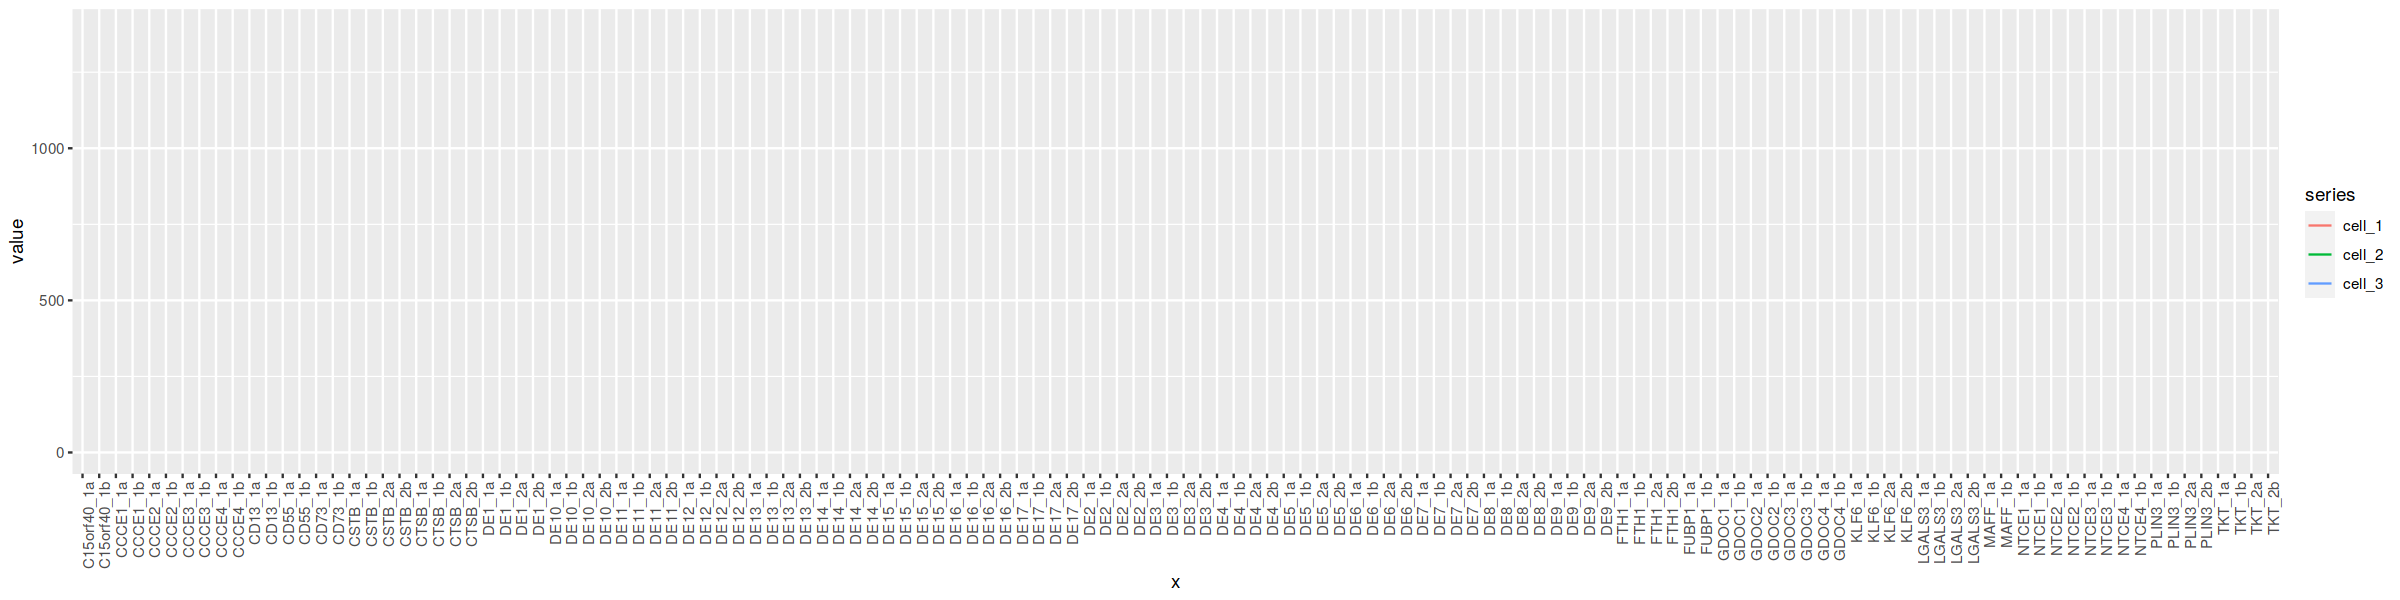

In [107]:
df_dummy = as.data.frame(sgrna_counts[,1000:1002])
colnames(df_dummy) <- c("cell_1", "cell_2","cell_3")
df_dummy$x = rownames(df_dummy)
df_dummy <- melt(df_dummy, id.vars = 'x', variable.name = 'series')

options(repr.plot.width=20, repr.plot.height=5)
ggplot(df_dummy, aes(x=x, y=value)) +
    geom_line(aes(colour = series)) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) 


In [106]:
head(df_dummy, 30)

,x,series,value
,<chr>,<fct>,<dbl>
1,CD13_1a,cell_1,0
2,CD13_1b,cell_1,0
3,CD55_1a,cell_1,0
4,CD55_1b,cell_1,0
5,CD73_1a,cell_1,1
6,CD73_1b,cell_1,0
7,FUBP1_1a,cell_1,2
8,FUBP1_1b,cell_1,0
9,C15orf40_1a,cell_1,2


In [24]:
seurat_unfiltered <- CreateSeuratObject(counts = rna_counts, project = prj_name)
sgrna_assay       <- CreateAssayObject(counts = sgrna_counts)
seurat_unfiltered[["sgRNA"]] <- sgrna_assay

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


### Import demux counts from Cellranger

In [25]:
df_thresholds = read.csv(umi_thresholds_path)
df_ps_calls   = read.csv(ps_calls_path)

In [26]:
guide_calls_list         = list()
construct_calls_list     = vector()
target_calls_list          = list() 
num_construct_calls_list = list()
num_guide_calls_list     = list()

for(call in df_ps_calls$feature_call) {
    calls <- strsplit(call, "\\|")[[1]]
    guide_calls <- calls
    
    calls <- gsub("_1.", "_1", calls)
    calls <- gsub("_2.", "_2", calls)
    calls <- unique(calls)
    target_calls <- paste(unique(gsub("_[0-9]*", "", calls)), collapse = "|")

    target_calls_list        <- c(target_calls_list, target_calls)
    construct_calls_list     <- c(construct_calls_list, paste(calls, collapse = "|"))
    num_construct_calls_list <- c(num_construct_calls_list, length(calls))
    guide_calls_list         <- c(guide_calls_list, list(guide_calls))
    num_guide_calls_list     <- c(num_guide_calls_list, length(guide_calls))
}
df_ps_calls$construct_call        <- as.factor(as.character(construct_calls_list))
df_ps_calls$num_called_constructs <- num_construct_calls_list
df_ps_calls$PS_call               <- guide_calls_list
df_ps_calls$num_PS_call           <- num_guide_calls_list
df_ps_calls$target_call           <- as.character(target_calls_list)

In [27]:
head(calls, 10)
head(target_calls)

[1] "TKT_2"    "LGALS3_1" "KLF6_2"   "DE8_1"    "DE9_1"    "DE12_1"   "DE17_1"  
[8] "NTCE4_1"  "CCCE1_1"

[1] "TKT|LGALS3|KLF6|DE8|DE9|DE12|DE17|NTCE4|CCCE1"

In [31]:
head(df_ps_calls)

,cell_barcode,num_features,feature_call,num_umis,construct_call,num_called_constructs,PS_call,num_PS_call,target_call
,<chr>,<int>,<chr>,<chr>,<fct>,<list>,<list>,<list>,<chr>
AGCTCAATCGTAGGGA-1,AGCTCAATCGTAGGGA-1,1,C15orf40_1a,57,C15orf40_1,1,C15orf40_1a,1,C15orf40
CAACAGTTCCTAGCGG-1,CAACAGTTCCTAGCGG-1,1,C15orf40_1a,1383,C15orf40_1,1,C15orf40_1a,1,C15orf40
AAACGCTCAGTTAGAA-1,AAACGCTCAGTTAGAA-1,2,C15orf40_1a|C15orf40_1b,1302|1753,C15orf40_1,1,"C15orf40_1a, C15orf40_1b",2,C15orf40
AAAGGATAGCGATTCT-1,AAAGGATAGCGATTCT-1,2,C15orf40_1a|C15orf40_1b,428|1565,C15orf40_1,1,"C15orf40_1a, C15orf40_1b",2,C15orf40
ATCGGCGGTCTAGATC-1,ATCGGCGGTCTAGATC-1,2,C15orf40_1a|C15orf40_1b,1515|3322,C15orf40_1,1,"C15orf40_1a, C15orf40_1b",2,C15orf40
ATTCCCGCATCCGCGA-1,ATTCCCGCATCCGCGA-1,2,C15orf40_1a|C15orf40_1b,606|1592,C15orf40_1,1,"C15orf40_1a, C15orf40_1b",2,C15orf40


<font color='red'>Keep only the cells with PS calls from Cellranger (skip this if you switch to another demux algo)</font> !!!!


In [28]:
cells_w_PS_calls <- df_ps_calls$cell_barcode
seurat_unfiltered <- subset(seurat_unfiltered, cells = cells_w_PS_calls)

In [33]:
my_cells = Cells(seurat_unfiltered)
rownames(df_ps_calls) <- df_ps_calls$cell_barcode

df_ps_calls_ordered_by_barcodes = df_ps_calls[my_cells,]

seurat_unfiltered@meta.data$PS_call            <- as.factor(df_ps_calls_ordered_by_barcodes$feature_call)
seurat_unfiltered@meta.data$construct_call     <- as.factor(df_ps_calls_ordered_by_barcodes$construct_call)
seurat_unfiltered@meta.data$target_call        <- as.factor(df_ps_calls_ordered_by_barcodes$target_call)
seurat_unfiltered@meta.data$nCalled_Constructs <- as.integer(df_ps_calls_ordered_by_barcodes$num_called_constructs)
seurat_unfiltered@meta.data$nPS_calls          <- as.integer(df_ps_calls_ordered_by_barcodes$num_PS_call)
seurat_unfiltered@meta.data$nCalled_sgRNA_UMIs <- df_ps_calls_ordered_by_barcodes$num_umis

In [34]:
head(seurat_unfiltered, 3)

,orig.ident,nCount_RNA,nFeature_RNA,nCount_sgRNA,nFeature_sgRNA,PS_call,construct_call,target_call,nCalled_Constructs,nPS_calls,nCalled_sgRNA_UMIs
,<fct>,<dbl>,<int>,<dbl>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<chr>
AGCTCAATCGTAGGGA-1,Screen1_66guides,32644,5712,92,9,C15orf40_1a,C15orf40_1,C15orf40,1,1,57
CAACAGTTCCTAGCGG-1,Screen1_66guides,40788,6939,1412,23,C15orf40_1a,C15orf40_1,C15orf40,1,1,1383
AAACGCTCAGTTAGAA-1,Screen1_66guides,44827,7247,3081,27,C15orf40_1a|C15orf40_1b,C15orf40_1,C15orf40,1,2,1302|1753


### Get mitochondrial content

In [35]:
seurat_unfiltered[["percent.mt"]] <-
    PercentageFeatureSet(seurat_unfiltered, pattern = "^MT-")

In [36]:
DefaultAssay(seurat_unfiltered) <- "RNA"

## QC

### Get RNA counts per cell

In [37]:
counts_per_cell <- Matrix::colSums(rna_counts)
cat("counts per cell: ", counts_per_cell[1:20], "\n") ## counts for first 5 cells

counts per cell:  25177 126284 43882 72819 63548 34134 58713 39586 41292 34276 85917 24140 52964 60166 44031 90062 42192 9360 53193 60136 


In [38]:
counts_per_gene <- Matrix::rowSums(rna_counts)
cat("counts per gene: ", counts_per_gene[1:20], "\n")  

counts per gene:  3 0 4 157 9 0 223 3 0 2 0 1 0 3 2711 4 3178 148 465 115 


In [39]:
genes_per_cell  <- Matrix::colSums(rna_counts > 0)       # count gene only if it has non-zero reads mapped.
guides_per_cell <- Matrix::colSums(sgrna_counts > 0)     # count gene only if it has non-zero reads mapped.

cat("counts for non-zero genes: ", genes_per_cell[1:5], "\n")  # counts for first 5 genes
cat("counts for non-zero guides:", guides_per_cell[1:5], "\n")  # counts for first 5 genes

counts for non-zero genes:  5887 11066 7417 9098 8607 
counts for non-zero guides: 19 28 31 22 20 


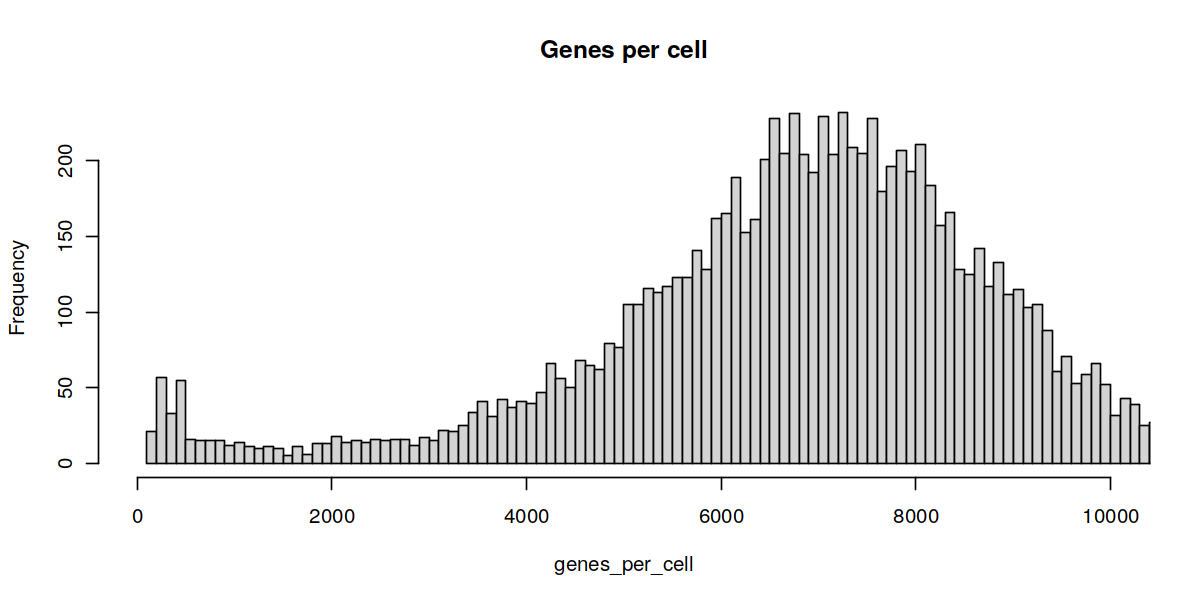

In [40]:
options(repr.plot.width=10, repr.plot.height=5)
#plot_log <- hist(log10(genes_per_cell), main="Genes per cell", breaks=100)
plot_lin <- hist(genes_per_cell, main="Genes per cell", breaks=100, xlim=c(1,10000))
#plot_guide_counts <- hist(guides_per_cell, main="Distinct protospacers per cell", breaks=100, xlim=c(1,100))

### --

### Plot RNA counts per cell 

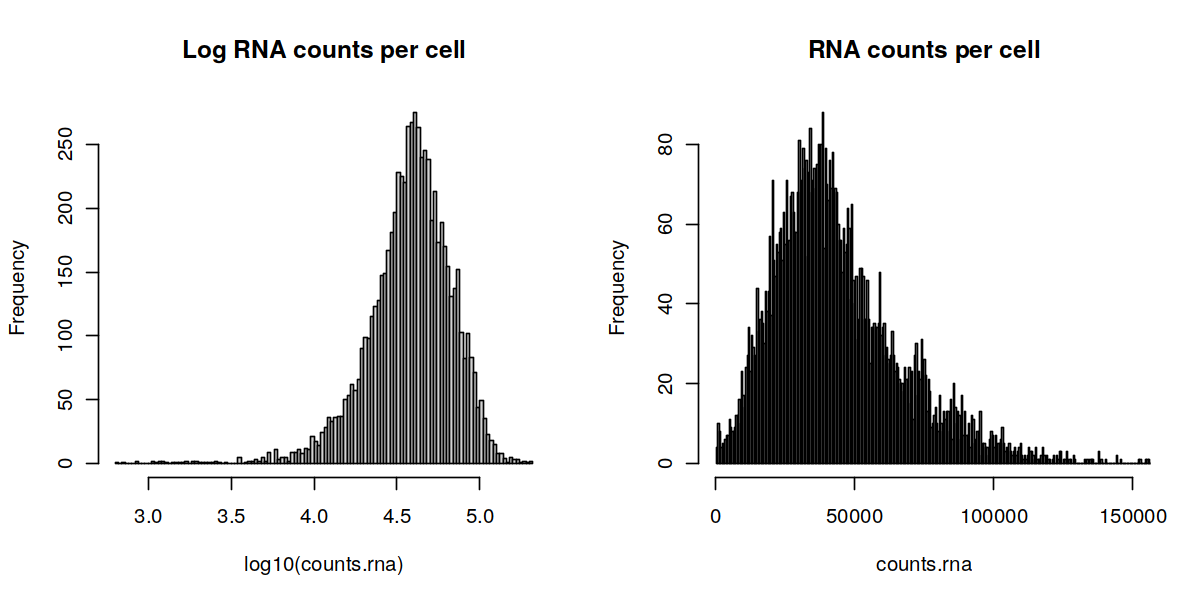

In [41]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
counts.rna <- seurat_unfiltered@meta.data$nCount_RNA
plot_log    <- hist(log10(counts.rna), main="Log RNA counts per cell", breaks=100)
plot_lin    <- hist(counts.rna, main="RNA counts per cell", breaks=500, xlim=c(1,150000))

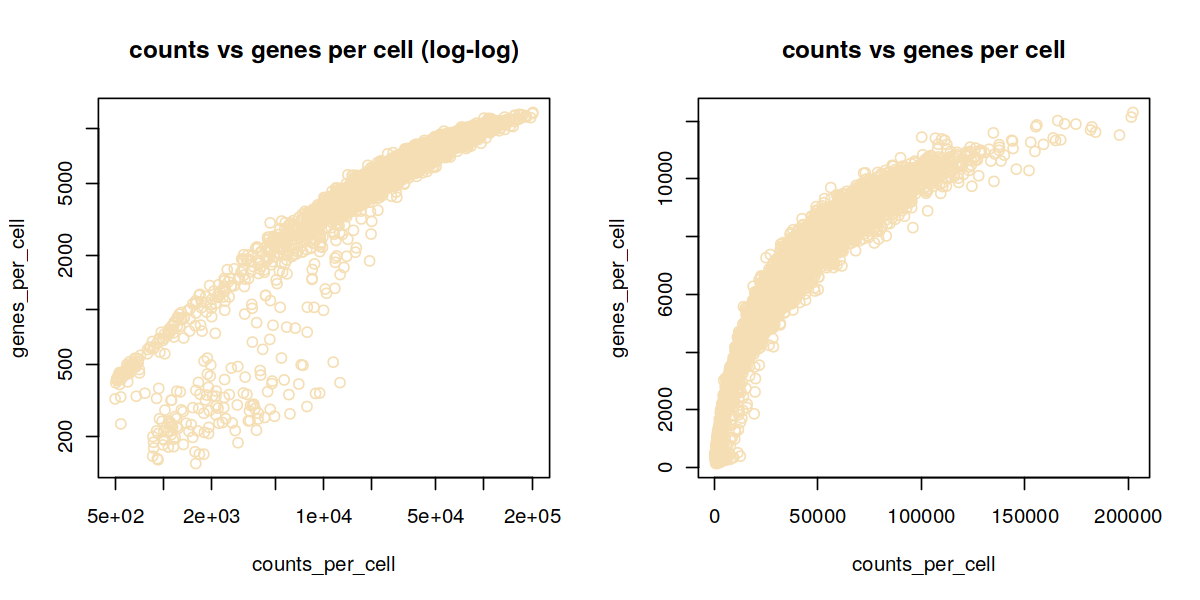

In [42]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
plot(counts_per_cell, genes_per_cell, log='xy', col='wheat')
title('counts vs genes per cell (log-log)')
plot(counts_per_cell, genes_per_cell, col='wheat')
title('counts vs genes per cell')

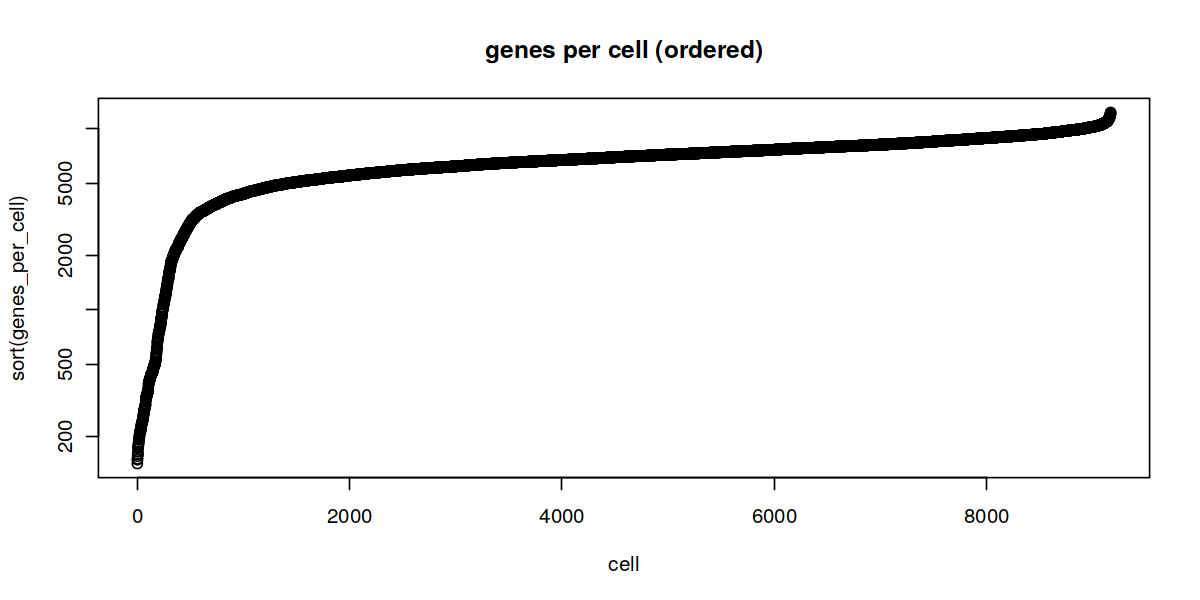

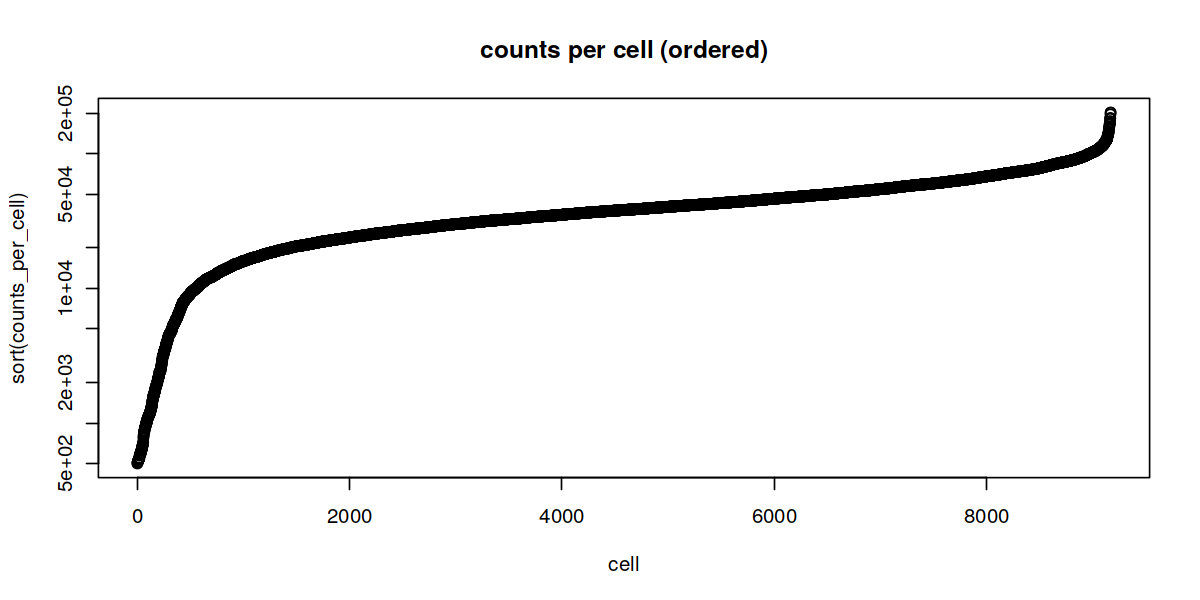

In [43]:
plot(sort(genes_per_cell), xlab='cell', log='y', main='genes per cell (ordered)')
plot(sort(counts_per_cell), xlab='cell', log='y', main='counts per cell (ordered)')

In [44]:
#FeatureScatter(object = seurat_unfiltered, feature1 = "nCount_RNA", feature2 = "nCount_ATAC", log)

### QC using houskeeping genes

In [45]:
# Load the the list of house keeping genes
hkgenes <- read.table("/home/vsevim/prj/tf/tf1/data/QC/housekeeping.txt", skip = 2)
hkgenes <- as.vector(hkgenes$V1)

In [46]:
# remove hkgenes that were not found
hkgenes.found <- which(toupper(rownames(seurat_unfiltered@assays$RNA@data)) %in% hkgenes)

In [47]:
num_hk_genes = length(hkgenes.found)
num_hk_genes

[1] 95

In [48]:
n.expressed.hkgenes <- Matrix::colSums(seurat_unfiltered@assays$RNA@data[hkgenes.found, ] > 0)

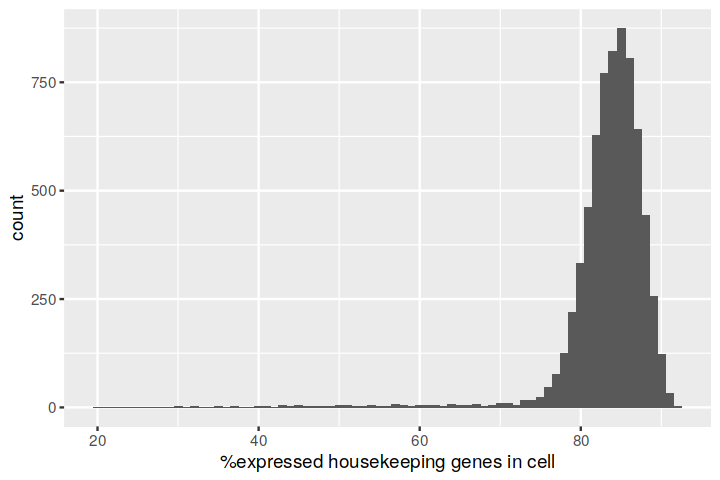

In [49]:
options(repr.plot.width=6, repr.plot.height=4)
df.expressed.hk <- data.frame(100*n.expressed.hkgenes/num_hk_genes)
ggplot(df.expressed.hk, aes(n.expressed.hkgenes)) + geom_histogram(binwidth=1) + labs(x="%expressed housekeeping genes in cell")

### QC by mitochondrial genes

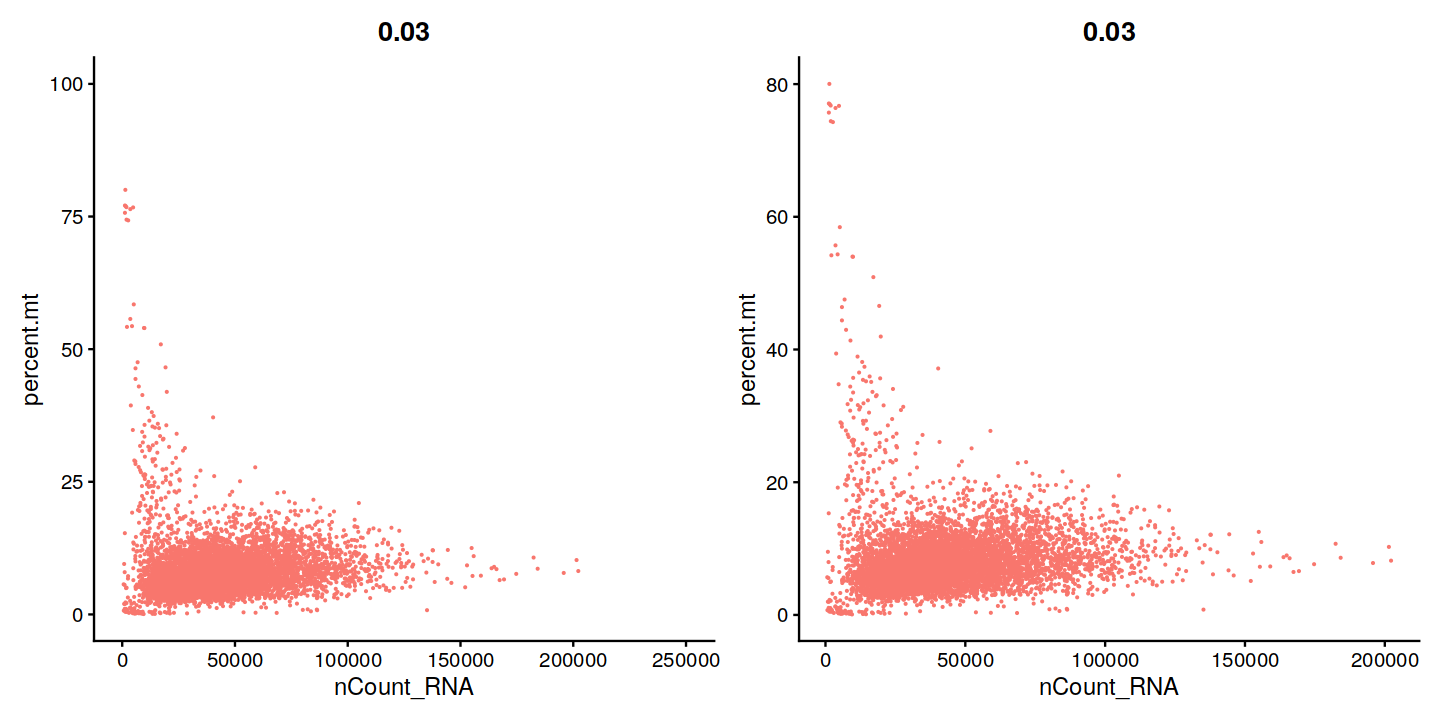

In [118]:
options(repr.plot.width=12, repr.plot.height=6)
plot1 <- FeatureScatter(seurat_unfiltered, feature1 = "nCount_RNA", feature2 = "percent.mt", pt.size=.1)
plot1 + xlim(c(0,250000)) + ylim(c(0,100)) + NoLegend() | plot1 + NoLegend()

## Filtering

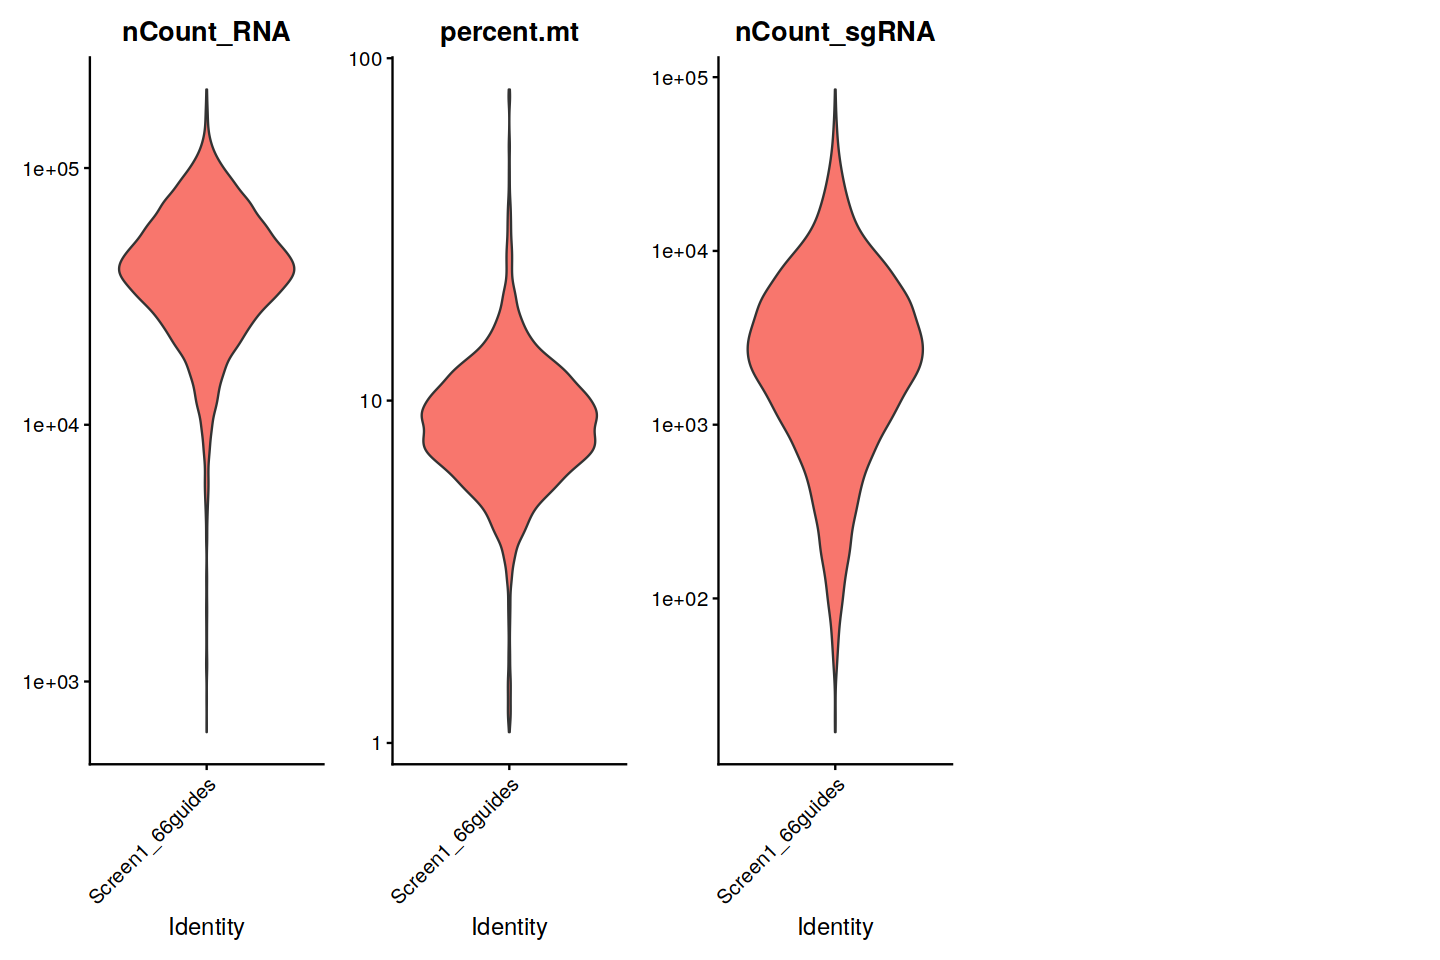

In [51]:
options(repr.plot.width=12, repr.plot.height=8)

VlnPlot(
  object = seurat_unfiltered,
  features = c("nCount_RNA", "percent.mt", "nCount_sgRNA"),
  ncol = 5,
  log=TRUE,
  pt.size = 0
)

### Filter out low quality cells

In [52]:
seurat <- subset(
  x = seurat_unfiltered,
  subset = nCount_RNA < 170000 &
    nCount_RNA > 6000 &
    percent.mt < 20 
)


In [123]:
length(Cells(subset(x = seurat_unfiltered,subset = percent.mt > 20)))
length(Cells(seurat_unfiltered))

[1] 140

[1] 6850

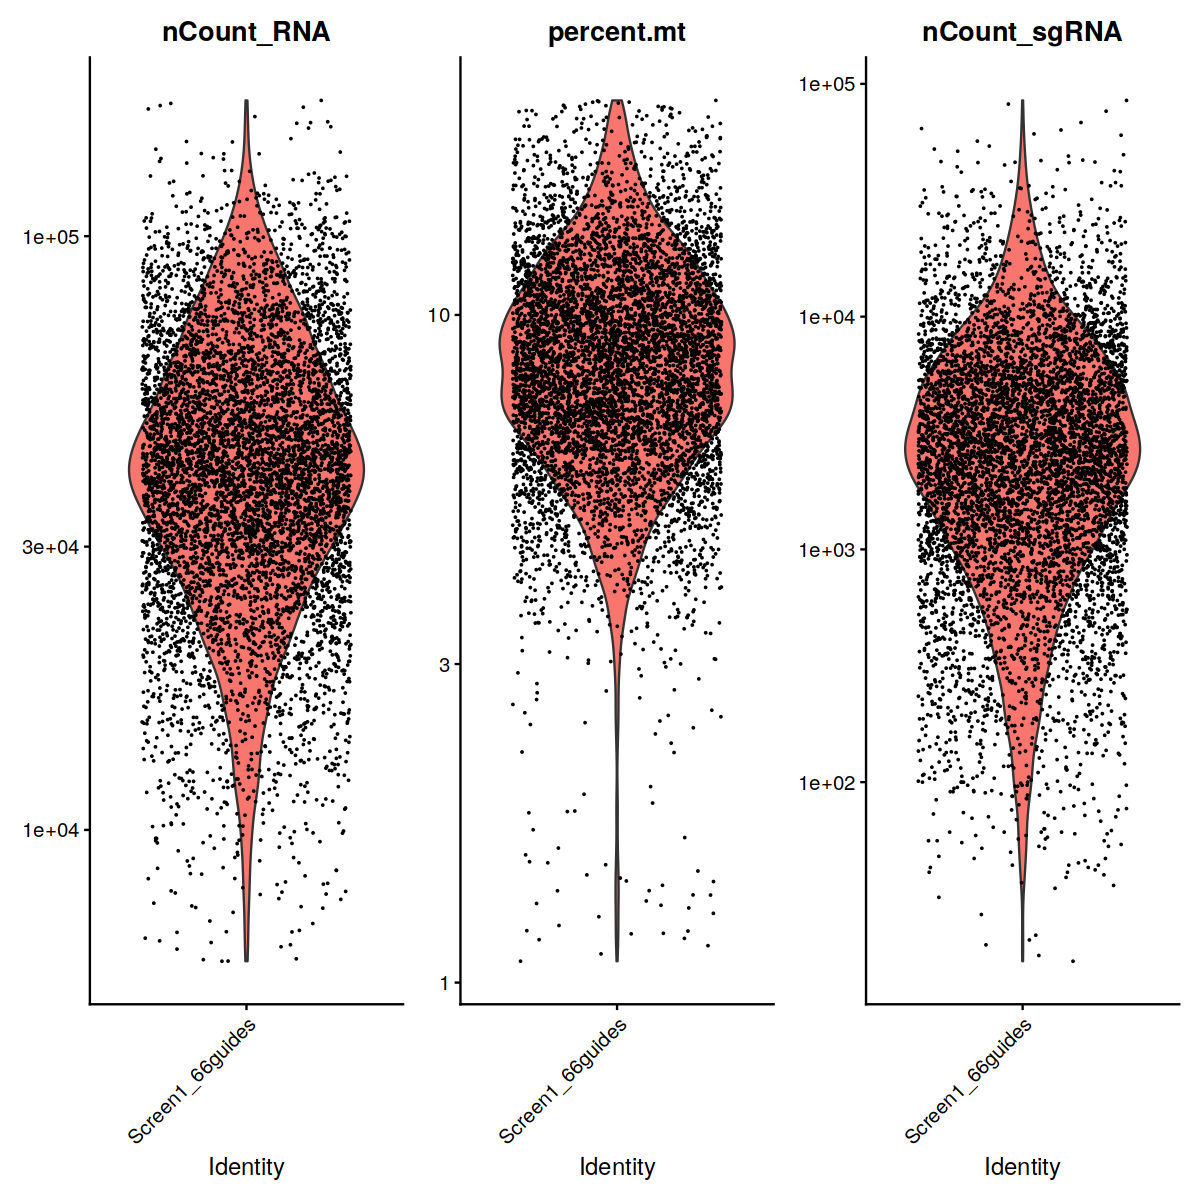

In [53]:
options(repr.plot.width=10, repr.plot.height=10)
VlnPlot(seurat, 
        features = c("nCount_RNA", "percent.mt", "nCount_sgRNA"), 
        ncol = 3, 
        log = TRUE, 
        pt.size = .01)

In [54]:
remaining_cells <- nrow(seurat@meta.data)

## Normalization, PCA, UMAP, SVD

### Normalize RNA assay

In [55]:
DefaultAssay(seurat) <- "RNA"
seurat <- SCTransform(seurat, vst.flavor = "v2", verbose = FALSE) %>% 
          RunPCA() %>% 
          RunUMAP(dims = 1:40, reduction.name = 'umap.rna', reduction.key = 'rnaUMAP_', verbose=FALSE)

PC_ 1 
Positive:  FTL, MT1X, CRYAB, APOE, FTH1, PLIN2, MT1E, S100A1, SOD2, G0S2 
	   SERPINA1, RRAD, NUPR1, MT2A, MGST1, ITPKA, FN1, CTSB, RARRES2, SERPINE1 
	   SAA1, GPX3, IL32, PDZK1IP1, AKR1C3, RPL13, GAS5, SQSTM1, VGF, RPL36 
Negative:  KCNIP4, ERBB4, MECOM, FAM155A, AC019197.1, WFDC2, PKHD1, PDE1A, MAL, BICC1 
	   KITLG, BST2, SKAP1, SFRP1, ACSL4, SNED1, EFNA5, DCDC2, DENND2A, LRP1B 
	   KAZN, PLCB4, SCN2A, HOXB3, XKR4, SGIP1, COBLL1, TFAP2B, NEAT1, SPON1 
PC_ 2 
Positive:  CENPF, TUBA1B, MKI67, TOP2A, HMGB2, TPX2, ASPM, PCLAF, DLGAP5, CEP55 
	   ANLN, CCNB1, HMMR, PBK, NUSAP1, PRC1, BIRC5, TUBB4B, PTTG1, CKS2 
	   CDKN3, GTSE1, RRM2, CDK1, STMN1, UBE2S, CENPE, H2AFZ, CDC20, UBE2C 
Negative:  MALAT1, NEAT1, MDM2, AC079352.1, FKBP5, SOD2, ZIM3, LINC01320, NRXN3, PTCHD4 
	   GBE1, FNIP2, KCNIP4, ADAMTS9-AS2, AL138828.1, CPD, MSC-AS1, MAGI2, GPC6, APOE 
	   AL357507.1, PKP4, SSBP2, ZNF385B, FGF14, SERPINA1, PDE4D, FHIT, FTH1, FTX 
PC_ 3 
Positive:  CDH6, HMGA2, NRXN3, FN1, CASC19, F

### Normalize sgRNA counts

In [56]:
seurat <- NormalizeData(
    seurat,
    assay = "sgRNA",
    normalization.method = "CLR"
)

Normalizing across features



Save to Seurat H5

In [57]:
if(save_seurat_h5 == "YES") {
    print("Saving h5...")
    SaveH5Seurat(seurat, filename=save_h5_file, overwrite=TRUE, verbose=FALSE)
}

In [58]:
head(seurat,5)

,orig.ident,nCount_RNA,nFeature_RNA,nCount_sgRNA,nFeature_sgRNA,PS_call,construct_call,target_call,nCalled_Constructs,nPS_calls,nCalled_sgRNA_UMIs,percent.mt,nCount_SCT,nFeature_SCT
,<fct>,<dbl>,<int>,<dbl>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<chr>,<dbl>,<dbl>,<int>
AGCTCAATCGTAGGGA-1,Screen1_66guides,32644,5712,92,9,C15orf40_1a,C15orf40_1,C15orf40,1,1,57,4.8,39417,5687
CAACAGTTCCTAGCGG-1,Screen1_66guides,40788,6939,1412,23,C15orf40_1a,C15orf40_1,C15orf40,1,1,1383,6.4,40545,6878
AAACGCTCAGTTAGAA-1,Screen1_66guides,44827,7247,3081,27,C15orf40_1a|C15orf40_1b,C15orf40_1,C15orf40,1,2,1302|1753,9.7,41368,7172
AAAGGATAGCGATTCT-1,Screen1_66guides,50419,7705,2006,14,C15orf40_1a|C15orf40_1b,C15orf40_1,C15orf40,1,2,428|1565,9.5,41469,7625
ATCGGCGGTCTAGATC-1,Screen1_66guides,40213,6389,4873,32,C15orf40_1a|C15orf40_1b,C15orf40_1,C15orf40,1,2,1515|3322,6.9,40246,6343


#### Group PS counts by target genes

In [59]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL
#df_guide_counts$n_guides <- rowSums(df_guide_counts)
head(df_guide_counts,2)
ncol(df_guide_counts)


,CD13-1a,CD13-1b,CD55-1a,CD55-1b,CD73-1a,CD73-1b,FUBP1-1a,FUBP1-1b,C15orf40-1a,C15orf40-1b,⋯,GDOC4-1a,GDOC4-1b,CCCE1-1a,CCCE1-1b,CCCE2-1a,CCCE2-1b,CCCE3-1a,CCCE3-1b,CCCE4-1a,CCCE4-1b
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,0,57,0,⋯,0,0,0,0,1,0,1,0,0,0
2,0,0,0,2,0,0,0,0,1383,0,⋯,1,0,0,0,0,0,0,0,1,0


[1] 132

In [60]:
ps_ids <- colnames(df_guide_counts)
ps_ids <- gsub("-1a", "", ps_ids)
ps_ids <- gsub("-1b", "", ps_ids)
ps_ids <- gsub("-2a", "", ps_ids)
ps_ids <- gsub("-2b", "", ps_ids)
ps_ids <- unique(ps_ids)

for (ps_id in ps_ids) {    
    df_guide_counts[, ps_id] <- rowSums(select(df_guide_counts, contains(ps_id)))
}

In [61]:
ps_ids

[1] "CD13"     "CD55"     "CD73"     "FUBP1"    "C15orf40" "MAFF"    
 [7] "FTH1"     "PLIN3"    "TKT"      "LGALS3"   "CSTB"     "CTSB"    
[13] "KLF6"     "DE1"      "DE2"      "DE3"      "DE4"      "DE5"     
[19] "DE6"      "DE7"      "DE8"      "DE9"      "DE10"     "DE11"    
[25] "DE12"     "DE13"     "DE14"     "DE15"     "DE16"     "DE17"    
[31] "NTCE1"    "NTCE2"    "NTCE3"    "NTCE4"    "GDOC1"    "GDOC2"   
[37] "GDOC3"    "GDOC4"    "CCCE1"    "CCCE2"    "CCCE3"    "CCCE4"

In [62]:
df_guides_by_target <- df_guide_counts[, ps_ids]
df_guides_by_target$total_targets <- rowSums(df_guides_by_target!=0)
head(df_guides_by_target)
ncol(df_guides_by_target)

,CD13,CD55,CD73,FUBP1,C15orf40,MAFF,FTH1,PLIN3,TKT,LGALS3,⋯,NTCE4,GDOC1,GDOC2,GDOC3,GDOC4,CCCE1,CCCE2,CCCE3,CCCE4,total_targets
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,57,0,0,0,0,1,⋯,0,0,0,0,0,0,1,1,0,9
2,0,2,0,0,1383,0,0,0,0,1,⋯,1,2,0,0,1,0,0,0,1,19
3,0,0,0,1,3055,0,0,0,1,0,⋯,0,0,1,0,1,1,1,1,2,24
4,0,0,0,0,1993,0,1,0,0,1,⋯,0,0,0,0,0,0,1,0,0,13
5,0,0,0,0,4837,0,0,1,0,2,⋯,1,0,0,0,0,0,0,1,1,24
6,0,0,0,0,2198,0,0,0,1,1,⋯,0,2,1,0,0,0,0,0,0,12


[1] 43

In [63]:
#sum(df_guides_by_target[, 'NTCE2'] > 0)

#### Group PS counts by construct

In [64]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL

ps_ids <- colnames(df_guide_counts)
ps_ids <- gsub("-1a", "-1", ps_ids)
ps_ids <- gsub("-1b", "-1", ps_ids)
ps_ids <- gsub("-2a", "-2", ps_ids)
ps_ids <- gsub("-2b", "-2", ps_ids)
ps_ids <- unique(ps_ids)

for (ps_id in ps_ids) {    
    df_guide_counts[, ps_id] <- rowSums(select(df_guide_counts, contains(ps_id)))
}
ps_ids
length(ps_ids)

[1] "CD13-1"     "CD55-1"     "CD73-1"     "FUBP1-1"    "C15orf40-1"
 [6] "MAFF-1"     "FTH1-1"     "FTH1-2"     "PLIN3-1"    "PLIN3-2"   
[11] "TKT-1"      "TKT-2"      "LGALS3-1"   "LGALS3-2"   "CSTB-1"    
[16] "CSTB-2"     "CTSB-1"     "CTSB-2"     "KLF6-1"     "KLF6-2"    
[21] "DE1-1"      "DE1-2"      "DE2-1"      "DE2-2"      "DE3-1"     
[26] "DE3-2"      "DE4-1"      "DE4-2"      "DE5-1"      "DE5-2"     
[31] "DE6-1"      "DE6-2"      "DE7-1"      "DE7-2"      "DE8-1"     
[36] "DE8-2"      "DE9-1"      "DE9-2"      "DE10-1"     "DE10-2"    
[41] "DE11-1"     "DE11-2"     "DE12-1"     "DE12-2"     "DE13-1"    
[46] "DE13-2"     "DE14-1"     "DE14-2"     "DE15-1"     "DE15-2"    
[51] "DE16-1"     "DE16-2"     "DE17-1"     "DE17-2"     "NTCE1-1"   
[56] "NTCE2-1"    "NTCE3-1"    "NTCE4-1"    "GDOC1-1"    "GDOC2-1"   
[61] "GDOC3-1"    "GDOC4-1"    "CCCE1-1"    "CCCE2-1"    "CCCE3-1"   
[66] "CCCE4-1"

[1] 66

In [65]:
df_guides_by_vector <- df_guide_counts[, ps_ids]
df_guides_by_vector$total_vectors <- rowSums(df_guides_by_vector!=0)
head(df_guides_by_vector)
ncol(df_guides_by_vector)

,CD13-1,CD55-1,CD73-1,FUBP1-1,C15orf40-1,MAFF-1,FTH1-1,FTH1-2,PLIN3-1,PLIN3-2,⋯,NTCE4-1,GDOC1-1,GDOC2-1,GDOC3-1,GDOC4-1,CCCE1-1,CCCE2-1,CCCE3-1,CCCE4-1,total_vectors
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,57,0,0,0,0,0,⋯,0,0,0,0,0,0,1,1,0,9
2,0,2,0,0,1383,0,0,0,0,0,⋯,1,2,0,0,1,0,0,0,1,21
3,0,0,0,1,3055,0,0,0,0,0,⋯,0,0,1,0,1,1,1,1,2,25
4,0,0,0,0,1993,0,1,0,0,0,⋯,0,0,0,0,0,0,1,0,0,12
5,0,0,0,0,4837,0,0,0,1,0,⋯,1,0,0,0,0,0,0,1,1,28
6,0,0,0,0,2198,0,0,0,0,0,⋯,0,2,1,0,0,0,0,0,0,14


[1] 67

### Visualize guide count distribution before demux

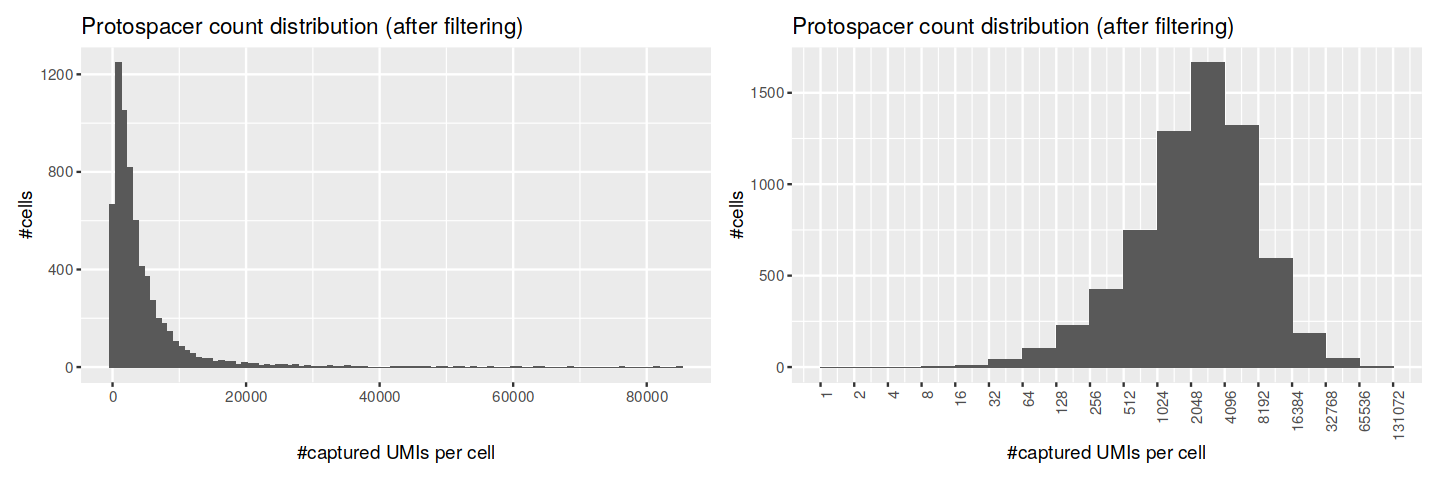

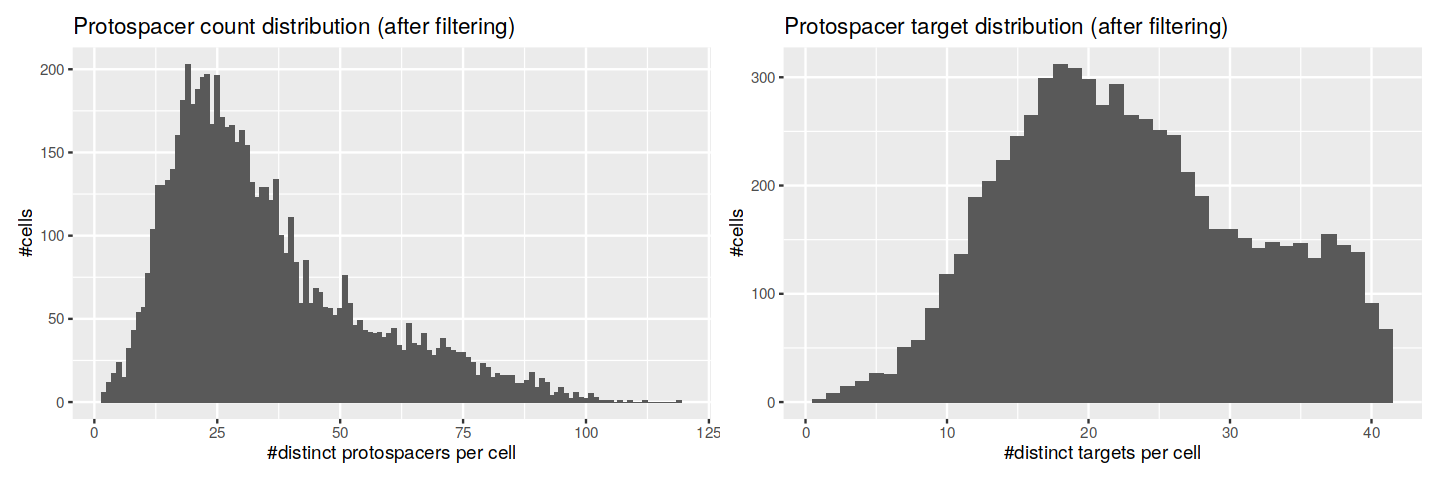

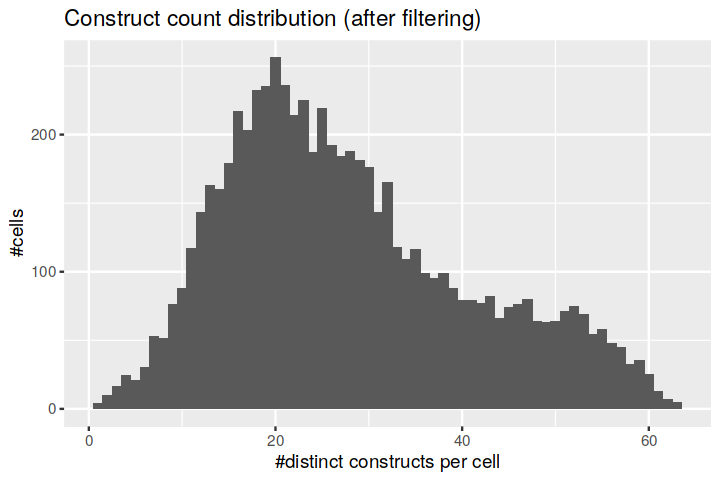

In [114]:
df_seurat <- seurat[[]]
bin_breaks <- c(1,2,2*2^(1:16))

p1 <- ggplot(df_seurat, aes(x = nCount_sgRNA)) +
    geom_histogram(bins=100) +
    labs(title = "Protospacer count distribution (after filtering)", x = "#captured UMIs per cell") +
    labs(y = "#cells") 

p1b <- ggplot(df_seurat, aes(x = nCount_sgRNA)) +
    geom_histogram(breaks=bin_breaks) +
    scale_x_log10(breaks=bin_breaks) +
    labs(title = "Protospacer count distribution (after filtering)", x = "#captured UMIs per cell") +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(y = "#cells") 

p2 <- ggplot(df_seurat, aes(x = nFeature_sgRNA)) +
    geom_histogram(binwidth=1) +
    labs(title = "Protospacer count distribution (after filtering)", x = "#distinct protospacers per cell") +
    labs(y = "#cells") 

p3 <- ggplot(df_guides_by_target, aes(x = total_targets)) +
    geom_histogram(binwidth=1) +
    labs(title = "Protospacer target distribution (after filtering)", x = "#distinct targets per cell") +
    labs(y = "#cells") 


p4 <- ggplot(df_guides_by_vector, aes(x = total_vectors)) +
    geom_histogram(binwidth=1) +
    labs(title = "Construct count distribution (after filtering)", x = "#distinct constructs per cell") +
    labs(y = "#cells") 

options(repr.plot.width=12, repr.plot.height=4)
p1 | p1b
p2 | p3
options(repr.plot.width=6, repr.plot.height=4)
p4

### Visualize guide count distribution before demux

In [67]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL
df_guide_counts$n_guides <- rowSums(df_guide_counts)

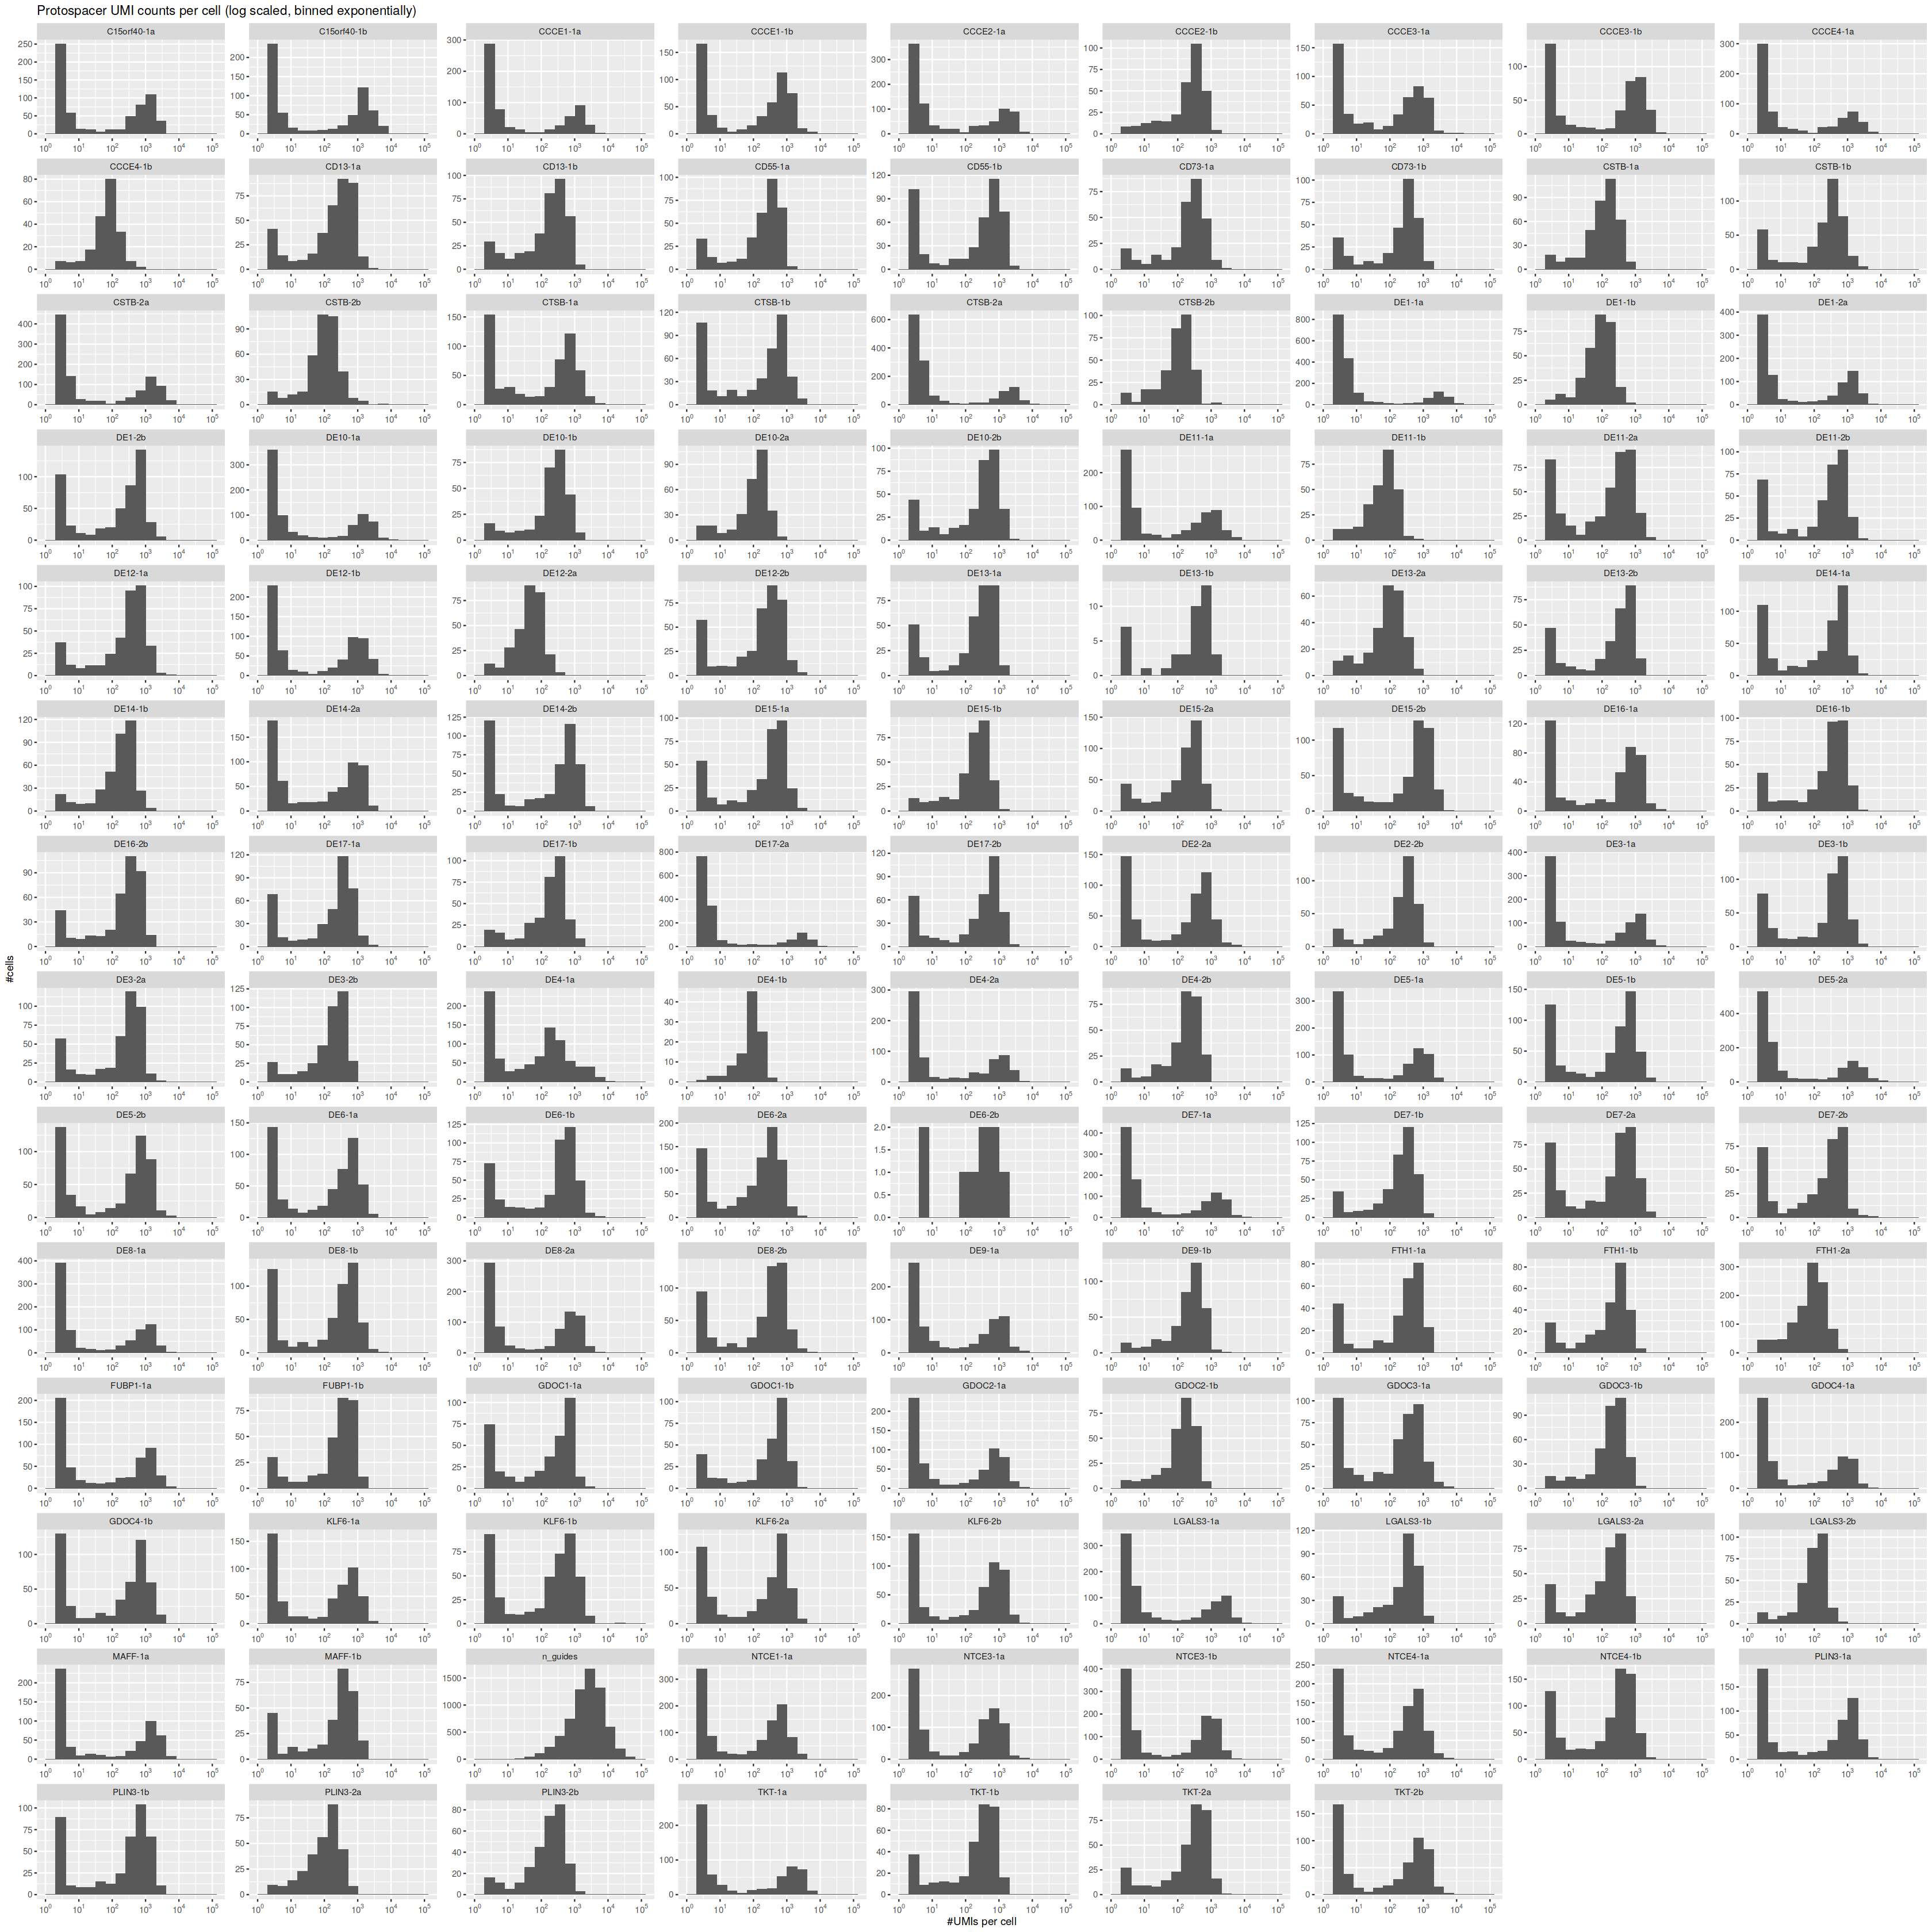

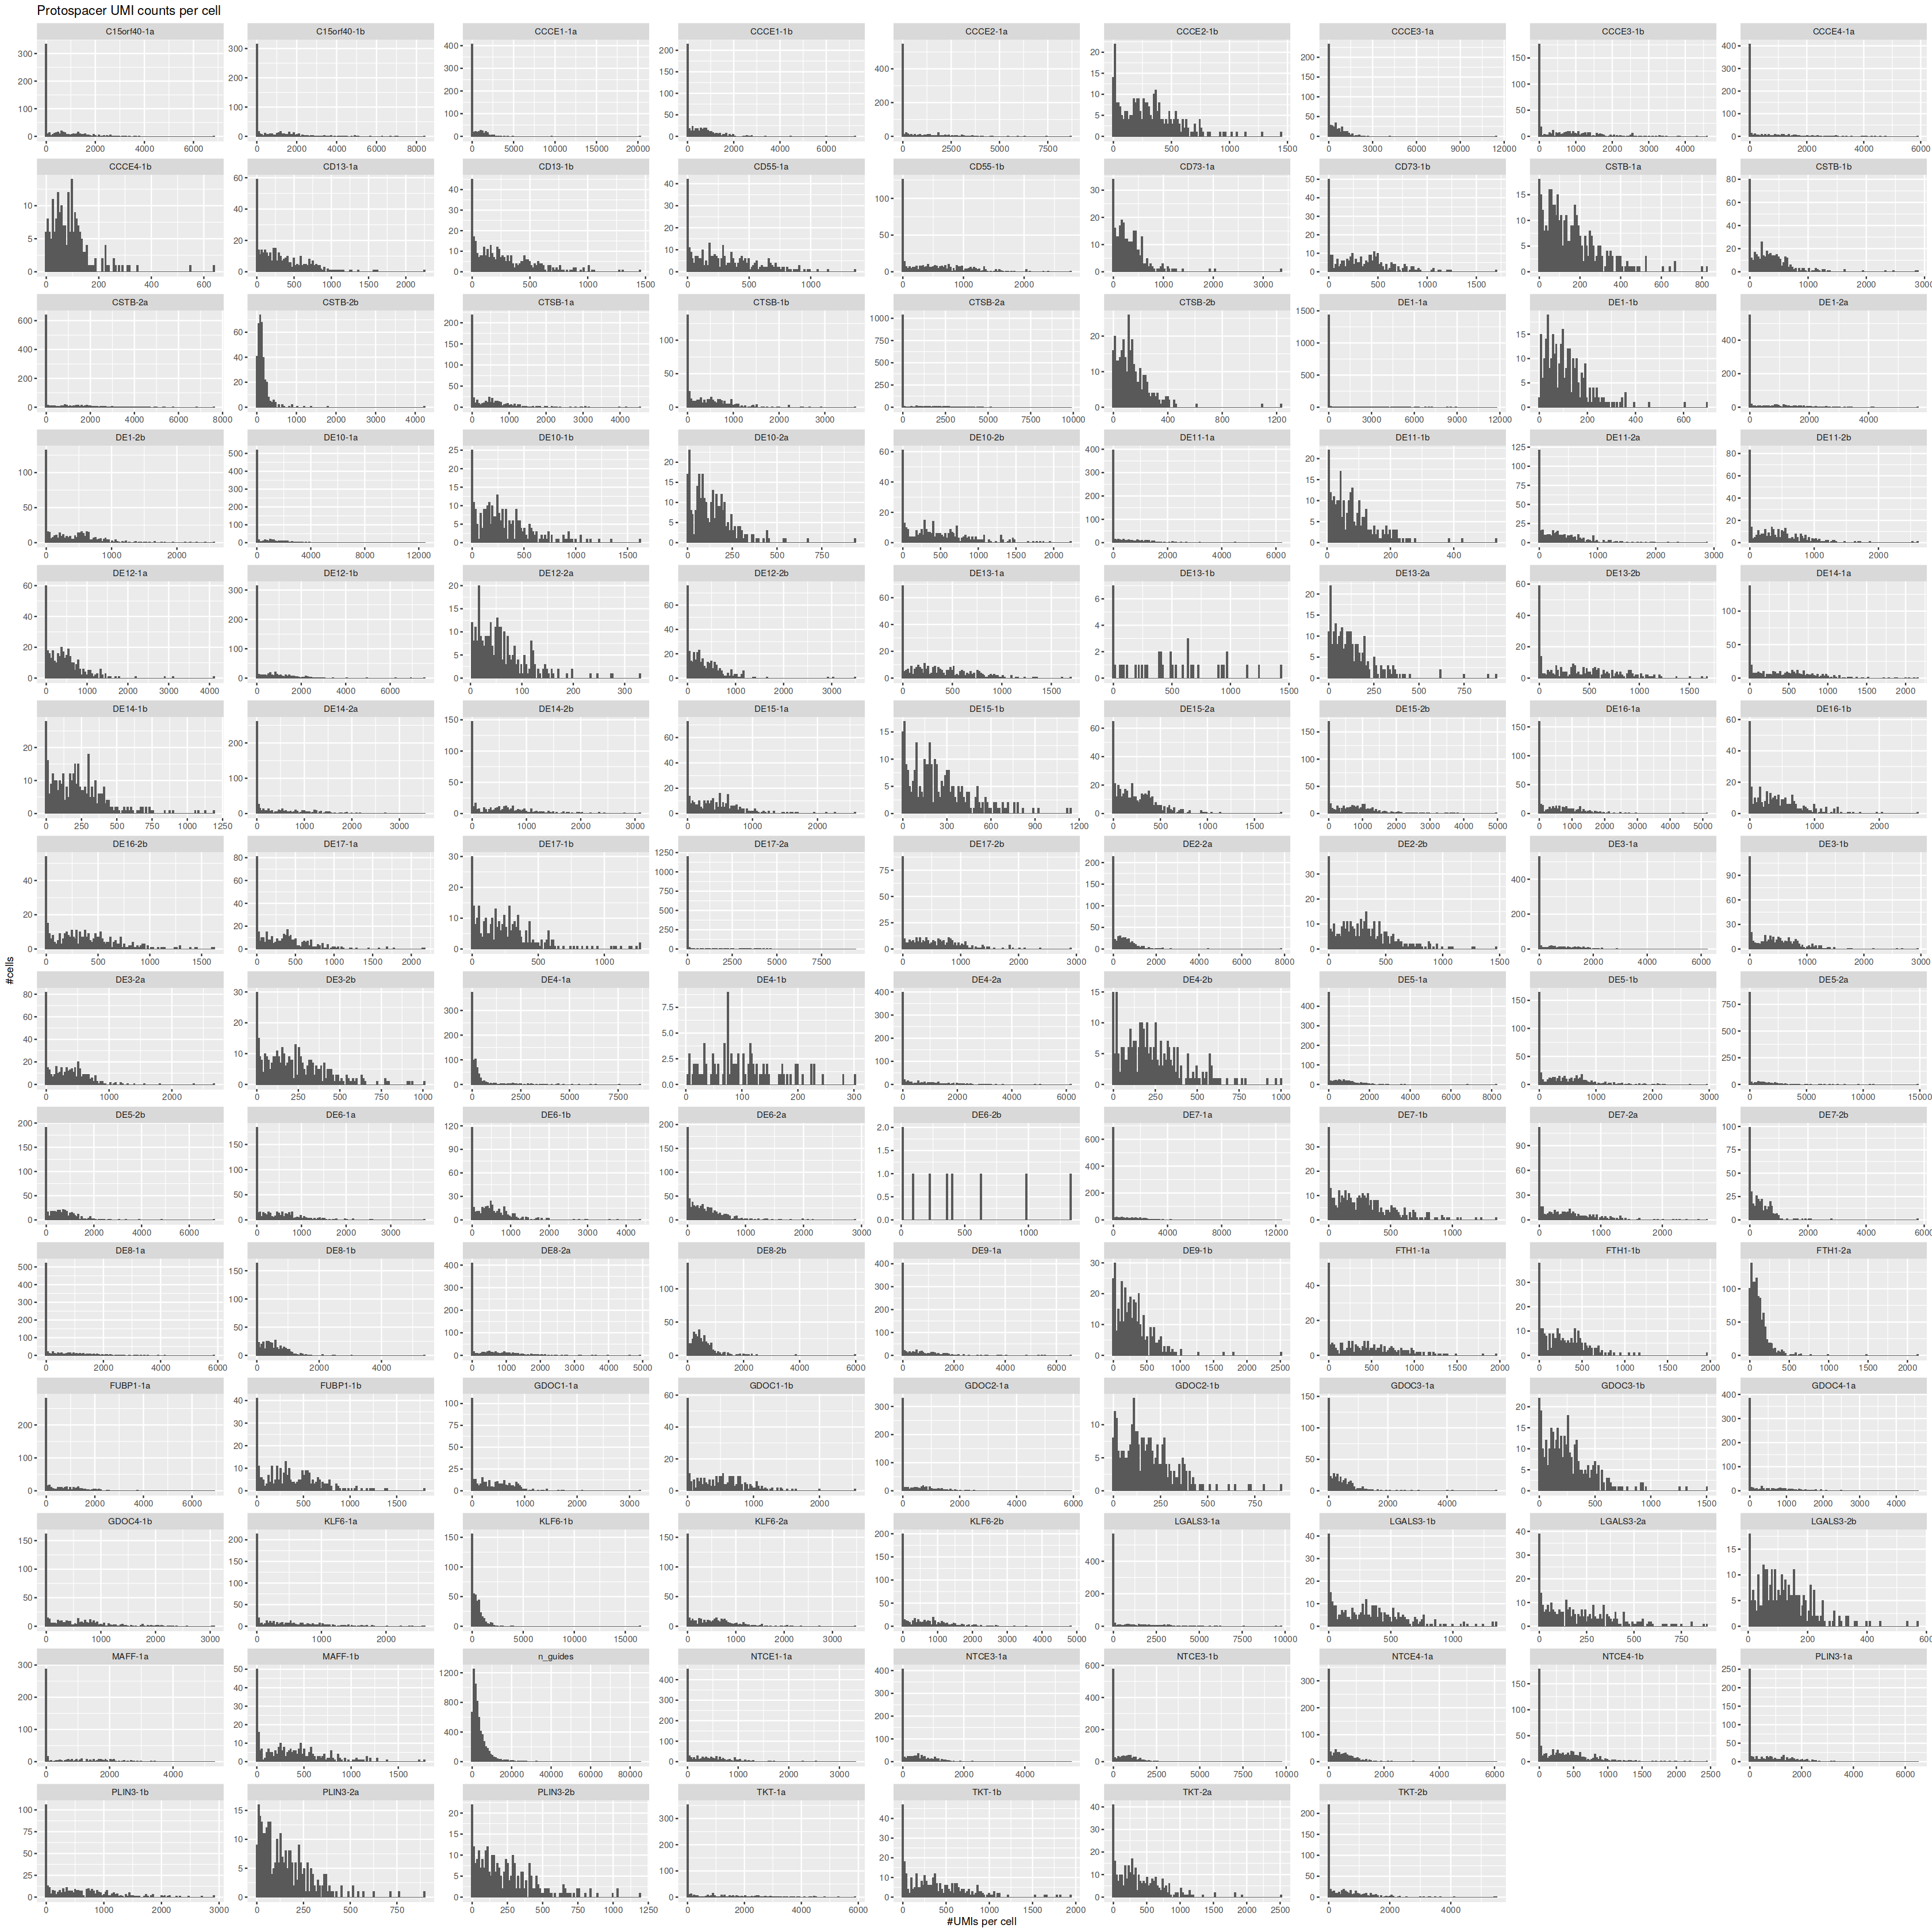

In [68]:
options(repr.plot.width=28, repr.plot.height=28)

data_long <- df_guide_counts %>%                    
  pivot_longer(colnames(df_guide_counts)) %>% 
  as.data.frame()

filter_zeros = data_long$value > 2
data_long <- data_long[filter_zeros,]
bin_breaks <- c(1,2,2*2^(1:16))

ggp1 <- ggplot(data_long, aes(x = value)) +    # Draw each column as histogram
  geom_histogram(breaks=bin_breaks) + 
  scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
  labs(title="Protospacer UMI counts per cell (log scaled, binned exponentially)", x="#UMIs per cell", y="#cells") +
  facet_wrap(~ name, scales = "free", ncol = 9)

ggp2 <- ggplot(data_long, aes(x = value)) +    # Draw each column as histogram
  geom_histogram(bins=100) + 
  labs(title="Protospacer UMI counts per cell", x="#UMIs per cell", y="#cells") +
  facet_wrap(~ name, scales = "free", ncol = 9)

ggp1
ggp2

# Plot Cellranger-demuxed counts (guide assignment)

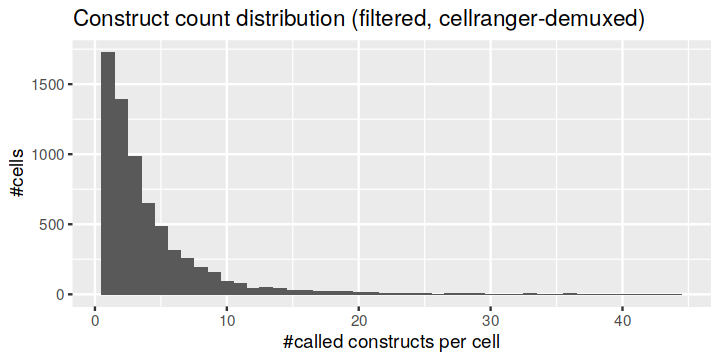

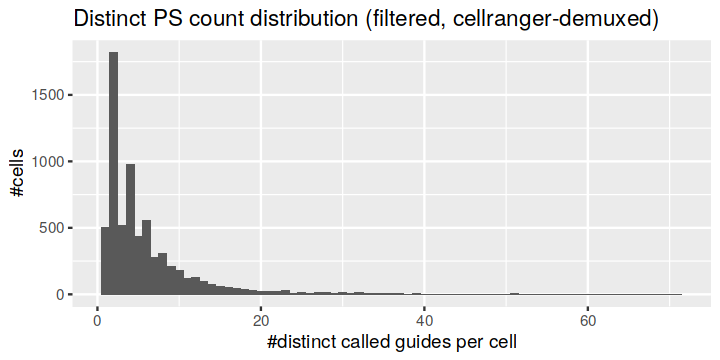

In [87]:
df_metadata = seurat@meta.data

p5 <- ggplot(df_metadata, aes(x = nCalled_Constructs)) +
    geom_histogram(binwidth=1) +
    labs(title = "Construct count distribution (filtered, cellranger-demuxed)", x = "#called constructs per cell") +
    labs(y = "#cells") 

p6 <- ggplot(df_metadata, aes(x = nPS_calls)) +
    geom_histogram(binwidth=1) +
    labs(title = "Distinct PS count distribution (filtered, cellranger-demuxed)", x = "#distinct called guides per cell") +
    labs(y = "#cells") 


options(repr.plot.width=6, repr.plot.height=3)
p5
p6

In [70]:
head(df_metadata)

,orig.ident,nCount_RNA,nFeature_RNA,nCount_sgRNA,nFeature_sgRNA,PS_call,construct_call,target_call,nCalled_Constructs,nPS_calls,nCalled_sgRNA_UMIs,percent.mt,nCount_SCT,nFeature_SCT
,<fct>,<dbl>,<int>,<dbl>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<chr>,<dbl>,<dbl>,<int>
AGCTCAATCGTAGGGA-1,Screen1_66guides,32644,5712,92,9,C15orf40_1a,C15orf40_1,C15orf40,1,1,57,4.8,39417,5687
CAACAGTTCCTAGCGG-1,Screen1_66guides,40788,6939,1412,23,C15orf40_1a,C15orf40_1,C15orf40,1,1,1383,6.4,40545,6878
AAACGCTCAGTTAGAA-1,Screen1_66guides,44827,7247,3081,27,C15orf40_1a|C15orf40_1b,C15orf40_1,C15orf40,1,2,1302|1753,9.7,41368,7172
AAAGGATAGCGATTCT-1,Screen1_66guides,50419,7705,2006,14,C15orf40_1a|C15orf40_1b,C15orf40_1,C15orf40,1,2,428|1565,9.5,41469,7625
ATCGGCGGTCTAGATC-1,Screen1_66guides,40213,6389,4873,32,C15orf40_1a|C15orf40_1b,C15orf40_1,C15orf40,1,2,1515|3322,6.9,40246,6343
ATTCCCGCATCCGCGA-1,Screen1_66guides,30000,6331,2212,15,C15orf40_1a|C15orf40_1b,C15orf40_1,C15orf40,1,2,606|1592,9.7,39259,6288


In [71]:
# library("vcd")
# filter_outliers = df_metadata$nCalled_Constructs < 20 
# n_constructs = df_metadata[filter_outliers, ]$nCalled_Constructs
# gf1 = goodfit(n_constructs, "poisson")
# rootogram(gf1, xlab = "", rect_gp = gpar(fill="chartreuse4"))

In [115]:
mean_constructs   <- round(mean(df_metadata$nCalled_Constructs),2)
median_constructs <- round(median(df_metadata$nCalled_Constructs),2)
n_guide_assigned_cells   <- nrow(df_metadata)
n_filtered_cells <- length(Cells(seurat))

n_cells_from_cellranger = ncol(rna_counts)
n_protospacers = nrow(sgrna_counts)
n_genes = nrow(rna_counts)

In [116]:

cat(blue(prj_name, library_name), "\n")
cat(blue("#cells recovered:", n_cells_from_cellranger), "\n")
cat(blue("#cells after QC filtering:", n_filtered_cells), "\n")
cat(blue("#cells after guide assignment:", n_guide_assigned_cells), "\n")
cat(blue("#distinct protospacers in assay:", n_protospacers), "\n")
cat(blue("#mean, median constructs (MOI):", mean_constructs, median_constructs), "\n")

Screen1_66guides Lib_1 
#cells recovered: 9169 
#cells after QC filtering: 6653 
#cells after guide assignment: 6653 
#distinct protospacers in assay: 132 
#mean, median constructs (MOI): 4.03 3 


# Guide+/- counts

## Create a cell/target df

In [74]:
targets = colnames(df_guides_by_target)
rownames(df_guides_by_target) <- rownames(as.data.frame(t(seurat[['sgRNA']]@counts)))

In [75]:
df_targets <- subset(df_guides_by_target, select=-total_targets)

In [76]:
df_targets[] <- FALSE

In [77]:
for(barcode in rownames(df_guides_by_target)){
    target_list <- as.character(seurat@meta.data[barcode, 'target_call'])
    targets = strsplit(target_list, "\\|")[[1]]
    for(target in targets) {
        df_targets[barcode, target] <- TRUE
    }
}

Double-check the target assignments

In [78]:
for(bc in rownames(df_guides_by_target)){
    eq = sum(df_targets[bc,]) == length(strsplit(as.character(seurat@meta.data[bc,'target_call']), "\\|")[[1]])
    if(!eq) { 
        print(bc)
        break
    }
}


## Get counts for each target+/- set

In [79]:
n_cells = nrow(df_targets)
n_targets = ncol(df_targets)
df_pos_neg = data.frame(n_positives=rep(0,n_targets), n_negatives=rep(0, n_targets))
rownames(df_pos_neg) = colnames(df_targets)

for(target in colnames(df_targets)) {   
    n_pos <- sum(df_targets[, target] == TRUE)
    df_pos_neg[target, 'n_positives']  <- n_pos
    df_pos_neg[target, 'n_negatives']  <- n_cells - n_pos
    #cat(target, pos_count, neg_count, "\n")
}

select_nonzeros <- df_pos_neg[,'n_positives'] > 0
df_pos_neg <- df_pos_neg[select_nonzeros,]

In [80]:
head(df_pos_neg)

,n_positives,n_negatives
,<dbl>,<dbl>
CD13,418,6235
CD55,390,6263
CD73,338,6315
FUBP1,339,6314
C15orf40,391,6262
MAFF,330,6323


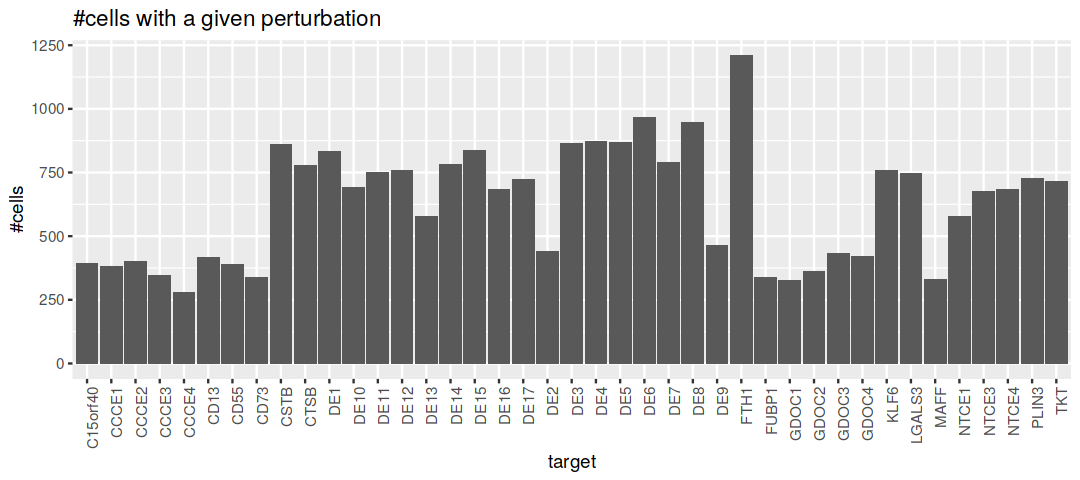

In [81]:
p6 <- ggplot(df_pos_neg, aes(x = rownames(df_pos_neg),y = n_positives)) +
    geom_bar(stat='identity') +
    labs(title = "#cells with a given perturbation", x = "target") +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(y = "#cells") 

options(repr.plot.width=9, repr.plot.height=4)
p6


In [82]:
sum(df_pos_neg$n_positives)
sum(df_metadata$nCalled_Constructs)

[1] 25720

[1] 26791

In [83]:
nrow(df_targets)
nrow(seurat@meta.data)

[1] 6653

[1] 6653

In [84]:
head(df_metadata)

,orig.ident,nCount_RNA,nFeature_RNA,nCount_sgRNA,nFeature_sgRNA,PS_call,construct_call,target_call,nCalled_Constructs,nPS_calls,nCalled_sgRNA_UMIs,percent.mt,nCount_SCT,nFeature_SCT
,<fct>,<dbl>,<int>,<dbl>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<chr>,<dbl>,<dbl>,<int>
AGCTCAATCGTAGGGA-1,Screen1_66guides,32644,5712,92,9,C15orf40_1a,C15orf40_1,C15orf40,1,1,57,4.8,39417,5687
CAACAGTTCCTAGCGG-1,Screen1_66guides,40788,6939,1412,23,C15orf40_1a,C15orf40_1,C15orf40,1,1,1383,6.4,40545,6878
AAACGCTCAGTTAGAA-1,Screen1_66guides,44827,7247,3081,27,C15orf40_1a|C15orf40_1b,C15orf40_1,C15orf40,1,2,1302|1753,9.7,41368,7172
AAAGGATAGCGATTCT-1,Screen1_66guides,50419,7705,2006,14,C15orf40_1a|C15orf40_1b,C15orf40_1,C15orf40,1,2,428|1565,9.5,41469,7625
ATCGGCGGTCTAGATC-1,Screen1_66guides,40213,6389,4873,32,C15orf40_1a|C15orf40_1b,C15orf40_1,C15orf40,1,2,1515|3322,6.9,40246,6343
ATTCCCGCATCCGCGA-1,Screen1_66guides,30000,6331,2212,15,C15orf40_1a|C15orf40_1b,C15orf40_1,C15orf40,1,2,606|1592,9.7,39259,6288
